---
title: Reviewing Mathematical and Computational Foundations for Machine Learning
author: Mark Fuge
date: 'October 26 2025'
format:
    html:
        code-fold: true
        code-summary: "Show Code"
---

This notebook is designed to help you build (or refresh) the conceptual and computational foundations needed for understanding probabilistic generative modeling methods and other important topics in Machine Learning. You can look at each sub-section independently and in any order to refresh your knowledge of some foundations, though we may build upon certain common examples throughout.

**Learning Objectives**

By the end of this notebook, you will be able to:

1. Understand random variables and Monte Carlo sampling techniques
2. Apply change of variables transformations and compute Jacobians
3. Work with linear algebra concepts relevant to probabilistic models, such as spectral norms of matrices
4. Compute gradients and understand curvature in optimization landscapes
5. Perform marginalization operations in probabilistic settings

In [1]:
# Standard numerical and plotting libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import multivariate_normal

# PyTorch for automatic differentiation
import torch
import torch.nn as nn

# For reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Plotting configuration
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['lines.linewidth'] = 2

## Random Variables, Monte Carlo, and Concentration Inequalities

### Concepts:

- Random variables are functions that map outcomes to numerical values
- **Expectations** represent the average value of a function over a probability distribution
- **Monte Carlo methods** use random sampling to approximate expectations and integrals
- The **Law of Large Numbers** ensures that sample averages converge to the true expectation as sample size increases
- Convergence rate is typically $O(1/\sqrt{N})$, meaning we need 4x more samples to halve the error
- Finite samples introduce uncertainty that decreases with more data and **Concentration Inequalities** (Chebyshev, Hoeffding) bound the probability of large deviations, which can help us understand real-world machine learning behavior

### Key Equations:

**Expectation via Monte Carlo:**
$$\mathbb{E}_{p(x)}[f(X)] = \int f(x) p(x) dx \approx \frac{1}{N} \sum_{i=1}^{N} f(x_i), \quad x_i \sim p(x)$$

**Intuition:** If we can sample from a distribution, we can approximate any expectation by averaging function values over those samples. The approximation improves as we collect more samples.

**Law of Large Numbers:**
$$\bar{X}_N = \frac{1}{N} \sum_{i=1}^{N} X_i \xrightarrow{N \to \infty} \mathbb{E}[X]$$

**Chebyshev's Inequality:**
$$P(|\bar{X}_N - \mu| \geq \epsilon) \leq \frac{\sigma^2}{N\epsilon^2}$$

**Hoeffding's Inequality (for bounded r.v. in $[a,b]$):**
$$P(|\bar{X}_N - \mu| \geq \epsilon) \leq 2\exp\left(-\frac{2N\epsilon^2}{(b-a)^2}\right)$$

Understanding convergence of statistical estimates of various functions will end up being foundational to many aspects of Machine Learning, so it is useful for us to build intuition about it ahead of time.

**Intuition:** These inequalities tell us how confident we can be that our sample mean is close to the true mean. They guarantee exponential or polynomial concentration as $N$ grows.

### Monte Carlo Mean Estimation

We'll sample from a standard normal distribution $\mathcal{N}(0, 1)$ and watch how the sample mean converges to the true mean (which is 0) as we increase the number of samples.

In [2]:
#| code-fold: false
# Set seed for reproducibility
np.random.seed(42)

# True parameters
true_mean = 0.0
true_std = 1.0

# Sample sizes to test
sample_sizes = np.logspace(1, 4, 50).astype(int)  # From 10 to 10,000 samples

# Compute sample means for increasing sample sizes
sample_means = []
confidence_intervals = []

for N in sample_sizes:
    # Draw N samples from standard normal
    samples = np.random.normal(true_mean, true_std, N)
    
    # Compute sample mean
    sample_mean = np.mean(samples)
    sample_means.append(sample_mean)
    
    # Compute 95% confidence interval (±1.96 * standard error)
    standard_error = np.std(samples) / np.sqrt(N)
    ci = 1.96 * standard_error
    confidence_intervals.append(ci)

sample_means = np.array(sample_means)
confidence_intervals = np.array(confidence_intervals)

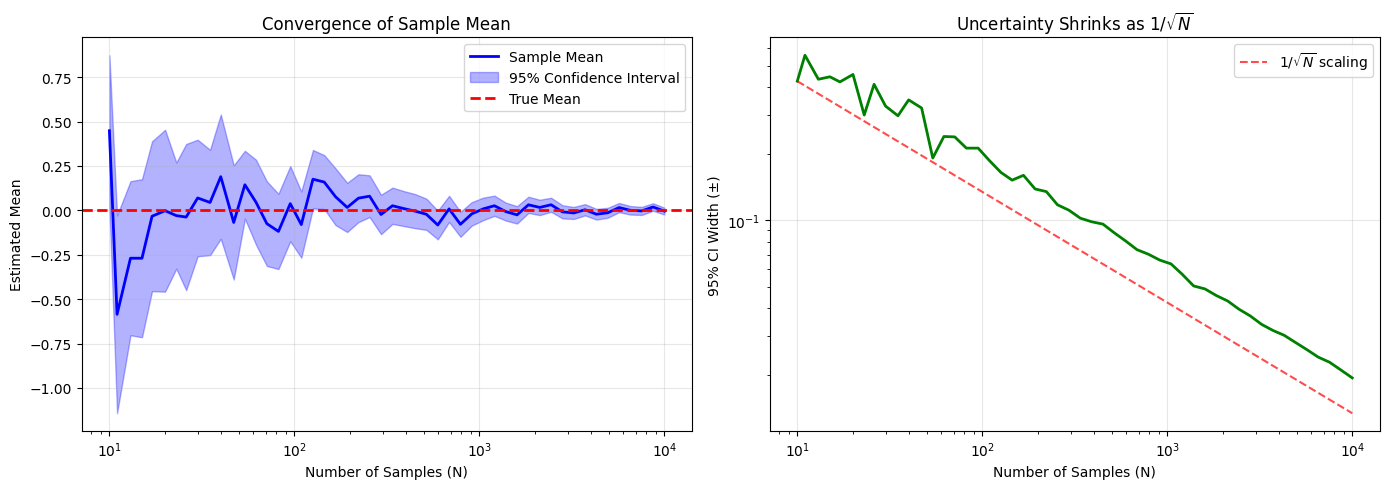

In [3]:
# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Sample mean convergence with confidence bands
ax1.plot(sample_sizes, sample_means, 'b-', linewidth=2, label='Sample Mean')
ax1.fill_between(sample_sizes, 
                  sample_means - confidence_intervals,
                  sample_means + confidence_intervals,
                  alpha=0.3, color='blue', label='95% Confidence Interval')
ax1.axhline(true_mean, color='r', linestyle='--', linewidth=2, label='True Mean')
ax1.set_xlabel('Number of Samples (N)')
ax1.set_ylabel('Estimated Mean')
ax1.set_xscale('log')
ax1.set_title('Convergence of Sample Mean')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right plot: Confidence interval width vs sample size
ax2.plot(sample_sizes, confidence_intervals, 'g-', linewidth=2)
ax2.set_xlabel('Number of Samples (N)')
ax2.set_ylabel('95% CI Width (±)')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title('Uncertainty Shrinks as $1/\\sqrt{N}$')
ax2.grid(True, alpha=0.3)

# Add reference line showing 1/sqrt(N) scaling
reference_line = confidence_intervals[0] * np.sqrt(sample_sizes[0]) / np.sqrt(sample_sizes)
ax2.plot(sample_sizes, reference_line, 'r--', linewidth=1.5, 
         label='$1/\\sqrt{N}$ scaling', alpha=0.7)
ax2.legend()

plt.tight_layout()
plt.show()

Notice how the sample mean oscillates around the true value but gradually settles down. The confidence interval shrinks, but not linearly—it follows a $1/\sqrt{N}$ pattern. This means:

- To halve your error, you need 4x more samples
- To reduce error by 10x, you need 100x more samples

Why do you think the convergence is so slow? What does this tell you about the computational cost of Monte Carlo methods, in general?

### Expectation of a Nonlinear Function

So far we've estimated the mean of a simple identity function. But Monte Carlo really shines when computing expectations of complex, nonlinear functions. Let's estimate $\mathbb{E}[X^2]$ where $X \sim \mathcal{N}(0, 1)$.

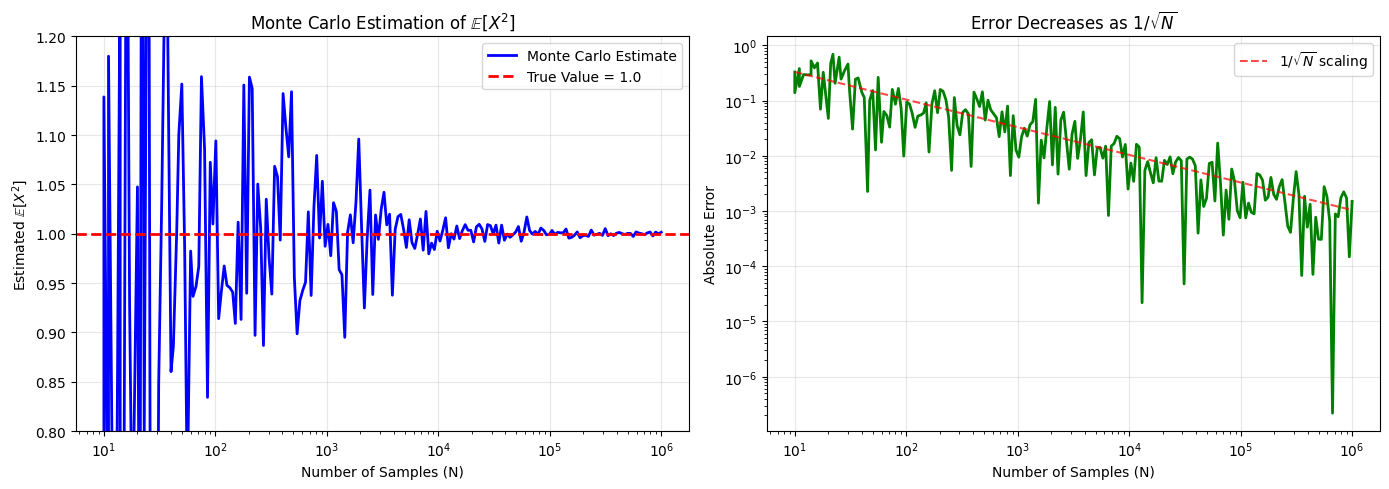

In [ ]:
#| code-fold: false
# For a standard normal, E[X^2] = Var(X) + E[X]^2 = 1 + 0 = 1
true_expectation = 1.0

# Generate samples and compute E[X^2]
np.random.seed(42)
sample_sizes = np.logspace(1, 6, 200).astype(int)

# Function we want to compute the expectation of
def f(x):
    return x**2

# Monte Carlo estimates
mc_estimates = []
for N in sample_sizes:
    samples = np.random.normal(0, 1, N)
    estimate = np.mean(f(samples))
    mc_estimates.append(estimate)

mc_estimates = np.array(mc_estimates)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Convergence to true value
ax1.plot(sample_sizes, mc_estimates, 'b-', linewidth=2, label='Monte Carlo Estimate')
ax1.axhline(true_expectation, color='r', linestyle='--', linewidth=2, 
            label=f'True Value = {true_expectation}')
ax1.set_xlabel('Number of Samples (N)')
ax1.set_ylabel('Estimated $\\mathbb{E}[X^2]$')
ax1.set_xscale('log')
ax1.set_title('Monte Carlo Estimation of $\\mathbb{E}[X^2]$')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0.8, 1.2)

# Right plot: Absolute error
absolute_error = np.abs(mc_estimates - true_expectation)
ax2.plot(sample_sizes, absolute_error, 'g-', linewidth=2)
ax2.set_xlabel('Number of Samples (N)')
ax2.set_ylabel('Absolute Error')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title('Error Decreases as $1/\\sqrt{N}$')
ax2.grid(True, alpha=0.3)

# Add reference line
reference = absolute_error[0] * np.sqrt(sample_sizes[0]) / np.sqrt(sample_sizes)
ax2.plot(sample_sizes, reference, 'r--', linewidth=1.5, 
         label='$1/\\sqrt{N}$ scaling', alpha=0.7)
ax2.legend()

plt.tight_layout()
plt.show()

## Change of Variables & Jacobians

### Concepts:

- When you transform a random variable, the probability density changes
- The **Jacobian matrix** captures how a transformation stretches or compresses space
- The **determinant of the Jacobian** computes how the volume scales in the new space operated on by the Jacobian
- This principle underlies **normalizing flows** and other generative models
- In 1D: $|\frac{dy}{dx}|$ tells us how density scales; in higher dimensions we use $|\det J|$

### Key Equations:

**Change of Variables Formula (1D):**
$$p_Y(y) = p_X(x) \left| \frac{dx}{dy} \right| = p_X(g^{-1}(y)) \left| \frac{dg^{-1}}{dy} \right|$$

where $y = g(x)$ is a transformation.

**Change of Variables Formula (Multidimensional):**
$$p_Y(y) = p_X(x) \left| \det \frac{\partial x}{\partial y} \right| = p_X(g^{-1}(y)) \left| \det J_{g^{-1}}(y) \right|$$

**Intuition:** When you transform a random variable, the probability density must be adjusted by how much the transformation stretches or compresses space. Think of it like this: if a transformation spreads points apart (stretches), the density must decrease to keep total probability = 1.

### Example: Linear Transformation (1D)

Let's start with a simple linear transformation: $y = 2x + 1$. We'll sample from a standard normal and see how the distribution changes. Recall that for a normal distribution $\mathcal{N}(\mu, \sigma^2)$, a linear transformation $y = ax + b$ results in $y \sim \mathcal{N}(a\mu + b, (a\sigma)^2)$. 

In this example, we should expect the expected mean of Y to be 1 and the standard deviation to be 2. Moreover, we should expect the density scaling factor from the Jacobian to be:

$$
\left| \frac{dx}{dy} \right| = \frac{1}{a} = 0.5
$$

which should be multiplied into the original density in the plots below.

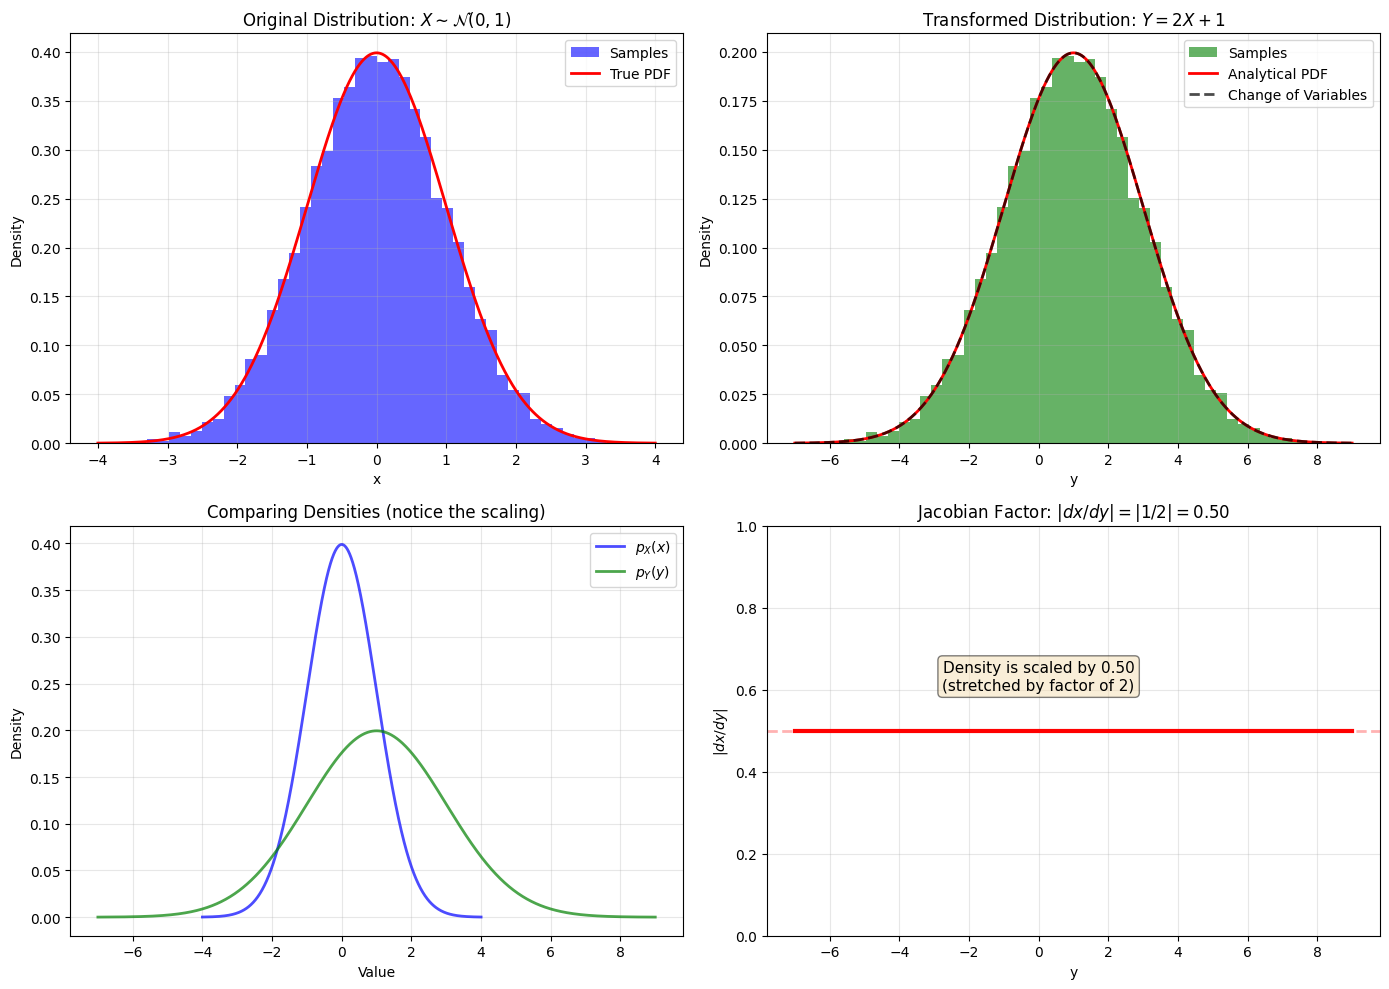

Sample mean of Y: 0.9957 (expected: 1)
Sample std of Y: 2.0068 (expected: 2.0000)

Jacobian factor |dx/dy| = 0.5000
Density is compressed by factor of 2


In [ ]:
# Sample from standard normal
np.random.seed(42)
n_samples = 10000
x_samples = np.random.normal(0, 1, n_samples)

# Apply linear transformation: y = 2x + 1
a, b = 2, 1
y_samples = a * x_samples + b

# For plotting, create a grid
x_grid = np.linspace(-4, 4, 1000)
y_grid = a * x_grid + b

# Original density: N(0, 1)
px = stats.norm.pdf(x_grid, 0, 1)

# Transformed density (analytical): N(a*0 + b, (a*1)^2)
py_analytical = stats.norm.pdf(y_grid, b, np.abs(a))

# Using change of variables: p_Y(y) = p_X((y-b)/a) * |1/a|
# For y = ax + b, we have x = (y-b)/a, so dx/dy = 1/a
py_cov = stats.norm.pdf((y_grid - b) / a, 0, 1) * np.abs(1/a)

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top left: Original samples histogram
axes[0, 0].hist(x_samples, bins=50, density=True, alpha=0.6, color='blue', label='Samples')
axes[0, 0].plot(x_grid, px, 'r-', linewidth=2, label='True PDF')
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('Original Distribution: $X \\sim \\mathcal{N}(0, 1)$')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Top right: Transformed samples histogram
axes[0, 1].hist(y_samples, bins=50, density=True, alpha=0.6, color='green', label='Samples')
axes[0, 1].plot(y_grid, py_analytical, 'r-', linewidth=2, label='Analytical PDF')
axes[0, 1].plot(y_grid, py_cov, 'k--', linewidth=2, label='Change of Variables', alpha=0.7)
axes[0, 1].set_xlabel('y')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title('Transformed Distribution: $Y = 2X + 1$')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Bottom left: Side-by-side comparison
axes[1, 0].plot(x_grid, px, 'b-', linewidth=2, label='$p_X(x)$', alpha=0.7)
# Plot transformed density on same scale (shift y_grid back to x scale for comparison)
axes[1, 0].plot(y_grid, py_analytical, 'g-', linewidth=2, label='$p_Y(y)$', alpha=0.7)
axes[1, 0].set_xlabel('Value')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_title('Comparing Densities (notice the scaling)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Bottom right: Derivative visualization
axes[1, 1].plot(y_grid, np.ones_like(y_grid) * np.abs(1/a), 'r-', linewidth=3)
axes[1, 1].axhline(np.abs(1/a), color='r', linestyle='--', alpha=0.3)
axes[1, 1].set_xlabel('y')
axes[1, 1].set_ylabel('$|dx/dy|$')
axes[1, 1].set_title(f'Jacobian Factor: $|dx/dy| = |1/{a}| = {np.abs(1/a):.2f}$')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim(0, 1)
axes[1, 1].text(0, 0.6, f'Density is scaled by {np.abs(1/a):.2f}\n' + 
                f'(stretched by factor of {np.abs(a)})', 
                fontsize=11, ha='center',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"Sample mean of Y: {np.mean(y_samples):.4f} (expected: {b})")
print(f"Sample std of Y: {np.std(y_samples):.4f} (expected: {np.abs(a):.4f})")

Notice how the transformation $y = 2x + 1$ shifts the mean (the $+1$ part) and stretches the distribution (the $2$ x part). The density gets compressed because the same probability mass is now spread over a wider range. 

The Jacobian factor $|dx/dy| = 1/2$ tells us exactly how much to scale the density.

### Example: Nonlinear Transformation

Linear transformations are straightforward, but what about nonlinear ones? Let's try $y = \tanh(x)$, which squashes values into the range $(-1, 1)$.

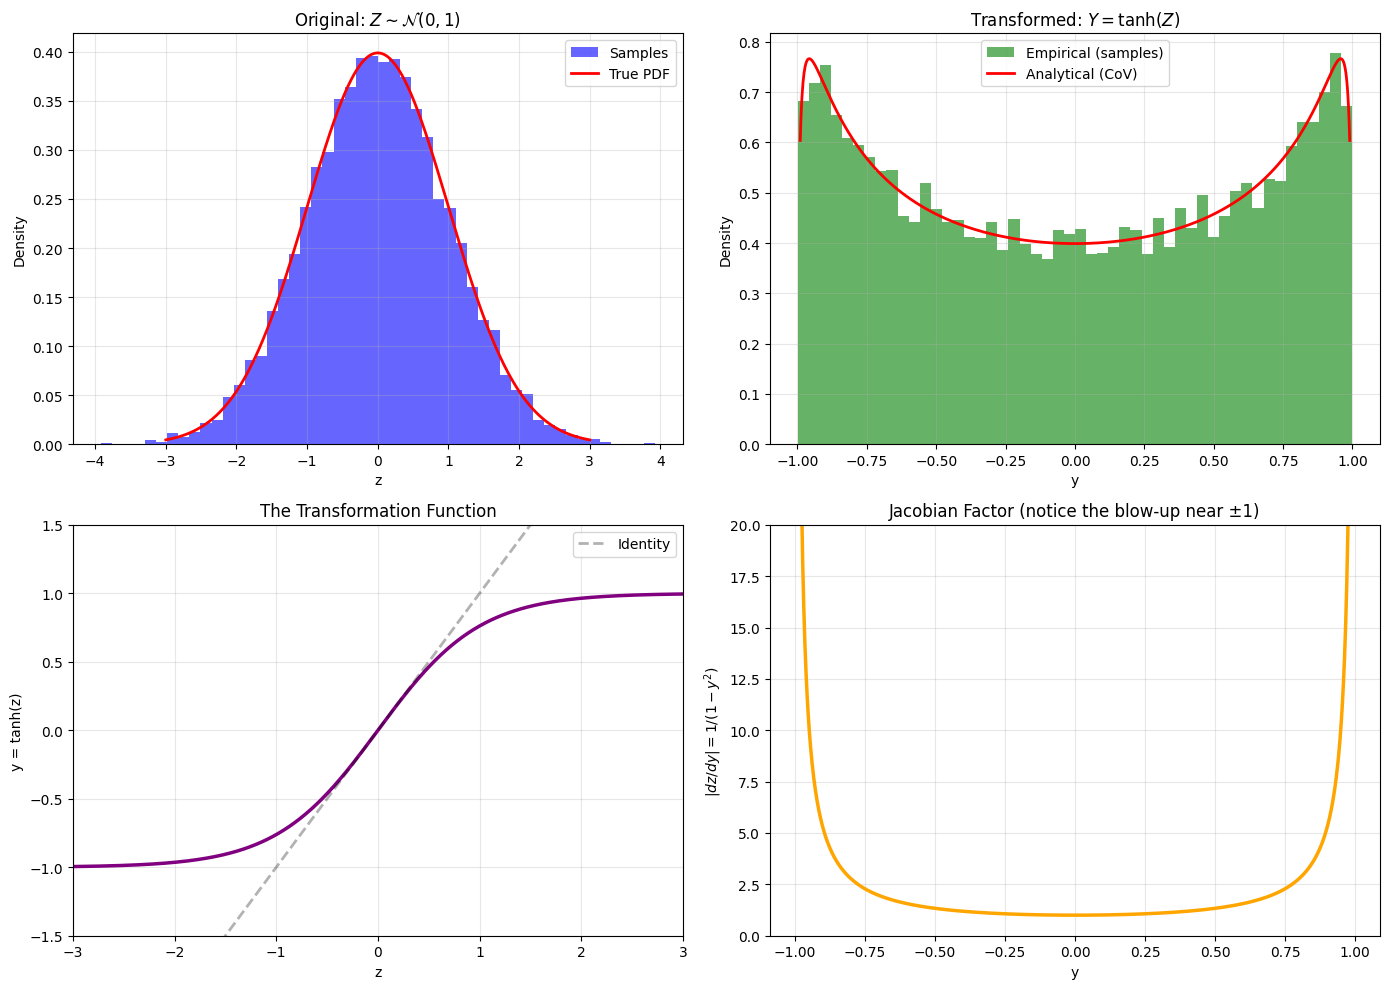

In [26]:
# Sample from standard normal
np.random.seed(42)
n_samples = 10000
z_samples = np.random.normal(0, 1, n_samples)

# Apply nonlinear transformation: y = tanh(z)
y_samples = np.tanh(z_samples)

# Create grids for visualization
z_grid = np.linspace(-3, 3, 1000)
y_grid = np.linspace(-0.99, 0.99, 1000)

# Original density
pz = stats.norm.pdf(z_grid, 0, 1)

# For transformed density, we need the inverse: z = arctanh(y)
# and the derivative: dz/dy = 1/(1-y^2)
z_from_y = np.arctanh(y_grid)
dz_dy = 1 / (1 - y_grid**2)

# Apply change of variables
py_analytical = stats.norm.pdf(z_from_y, 0, 1) * np.abs(dz_dy)

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top left: Original samples
axes[0, 0].hist(z_samples, bins=50, density=True, alpha=0.6, color='blue', label='Samples')
axes[0, 0].plot(z_grid, pz, 'r-', linewidth=2, label='True PDF')
axes[0, 0].set_xlabel('z')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('Original: $Z \\sim \\mathcal{N}(0, 1)$')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Top right: Transformed samples
axes[0, 1].hist(y_samples, bins=50, density=True, alpha=0.6, color='green', 
                label='Empirical (samples)')
axes[0, 1].plot(y_grid, py_analytical, 'r-', linewidth=2, label='Analytical (CoV)')
axes[0, 1].set_xlabel('y')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title('Transformed: $Y = \\tanh(Z)$')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Bottom left: Transformation function
axes[1, 0].plot(z_grid, np.tanh(z_grid), 'purple', linewidth=2.5)
axes[1, 0].plot(z_grid, z_grid, 'k--', alpha=0.3, label='Identity')
axes[1, 0].set_xlabel('z')
axes[1, 0].set_ylabel('y = tanh(z)')
axes[1, 0].set_title('The Transformation Function')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xlim(-3, 3)
axes[1, 0].set_ylim(-1.5, 1.5)

# Bottom right: Jacobian (derivative)
axes[1, 1].plot(y_grid, dz_dy, 'orange', linewidth=2.5)
axes[1, 1].set_xlabel('y')
axes[1, 1].set_ylabel('$|dz/dy| = 1/(1-y^2)$')
axes[1, 1].set_title('Jacobian Factor (notice the blow-up near ±1)')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim(0, 20)

plt.tight_layout()
plt.show()

The $\tanh$ function compresses the tails of the Gaussian distribution into a bounded range. Notice how the Jacobian factor $|dz/dy| = 1/(1-y^2)$ grows very large near $y = \pm 1$. This creates the characteristic "U-shaped" density—probability piles up where the transformation compresses most severely.

This type of transformation is common in neural networks (e.g., in activation functions). What do you think would happen if we used a transformation that wasn't invertible?

### Example: 2D Transformation and Grid Deformation

In higher dimensions, the Jacobian is a matrix, and its determinant tells us about volume changes. Let's visualize this with a 2D linear transformation.

Transformation matrix A:
[[ 1.73205081 -0.5       ]
 [ 1.          0.8660254 ]]

Determinant (area scaling factor): 2.0000


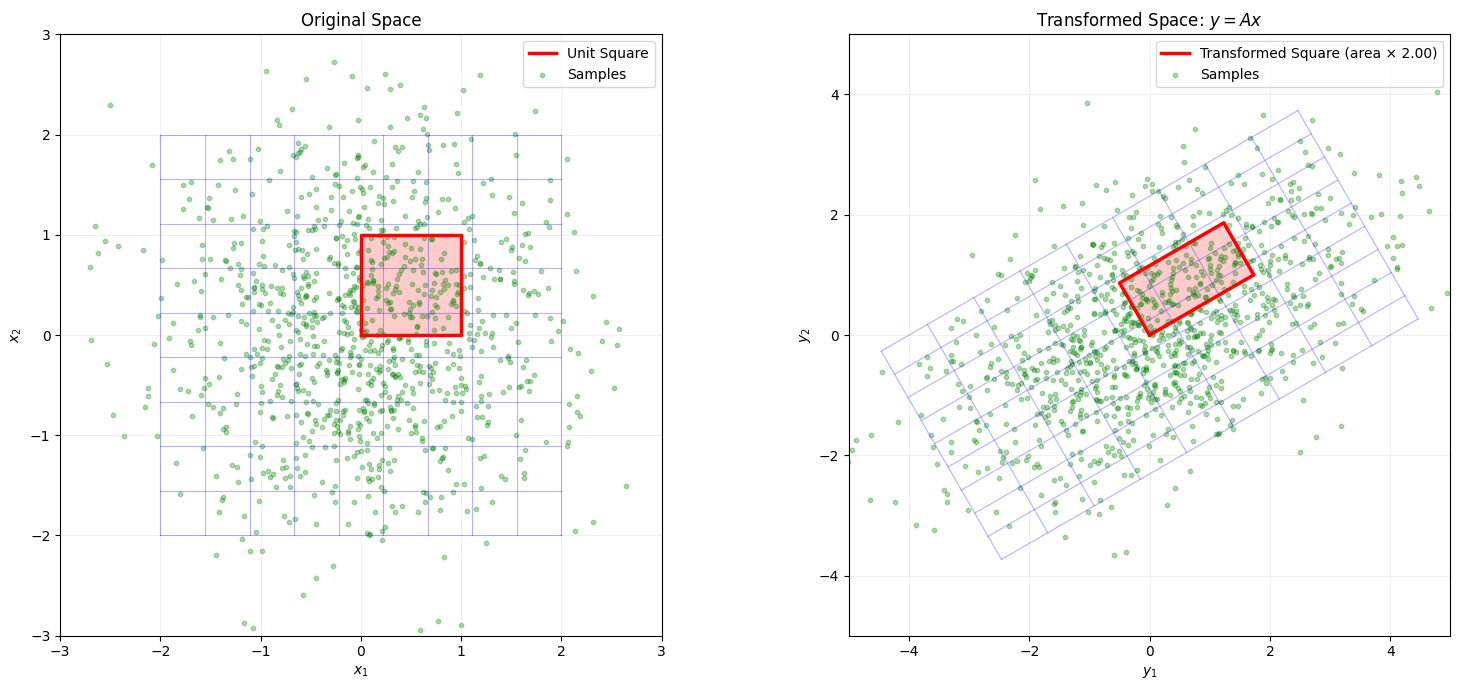


Original unit square area: 1.0000
Transformed square area: 2.0000
Area scaling factor: 2.0000

This means density must be scaled by 0.5000 to preserve probability mass


In [ ]:
# Define a 2D linear transformation matrix
# We'll use a matrix that scales by 2 in x-direction and rotates
theta = np.pi / 6  # 30 degrees
scale_x, scale_y = 2.0, 1.0

# Transformation matrix: scale then rotate
R = np.array([[np.cos(theta), -np.sin(theta)],
              [np.sin(theta), np.cos(theta)]])
S = np.array([[scale_x, 0],
              [0, scale_y]])
A = R @ S

print("Transformation matrix A:")
print(A)
print(f"\nDeterminant (area scaling factor): {np.linalg.det(A):.4f}")

# Create a regular grid
n_grid = 10
x_range = np.linspace(-2, 2, n_grid)
y_range = np.linspace(-2, 2, n_grid)
X, Y = np.meshgrid(x_range, y_range)

# Stack into points
points = np.stack([X.ravel(), Y.ravel()], axis=1)

# Transform the grid
transformed_points = points @ A.T
X_transformed = transformed_points[:, 0].reshape(X.shape)
Y_transformed = transformed_points[:, 1].reshape(Y.shape)

# Sample from 2D Gaussian
np.random.seed(42)
n_samples = 1000
samples = np.random.multivariate_normal([0, 0], np.eye(2), n_samples)
transformed_samples = samples @ A.T

# Create visualization
fig = plt.figure(figsize=(16, 7))

# Left plot: Original grid and samples
ax1 = fig.add_subplot(121)
# Draw grid lines
for i in range(n_grid):
    ax1.plot(X[i, :], Y[i, :], 'b-', alpha=0.3, linewidth=0.8)
    ax1.plot(X[:, i], Y[:, i], 'b-', alpha=0.3, linewidth=0.8)

# Draw a unit square to highlight
square = np.array([[0, 0], [1, 0], [1, 1], [0, 1], [0, 0]])
ax1.plot(square[:, 0], square[:, 1], 'r-', linewidth=2.5, label='Unit Square')
ax1.fill(square[:, 0], square[:, 1], 'red', alpha=0.2)

# Plot samples
ax1.scatter(samples[:, 0], samples[:, 1], c='green', alpha=0.3, s=10, label='Samples')

ax1.set_xlabel('$x_1$')
ax1.set_ylabel('$x_2$')
ax1.set_title('Original Space')
ax1.legend()
ax1.grid(True, alpha=0.2)
ax1.set_aspect('equal')
ax1.set_xlim(-3, 3)
ax1.set_ylim(-3, 3)

# Right plot: Transformed grid and samples
ax2 = fig.add_subplot(122)
# Draw transformed grid lines
for i in range(n_grid):
    ax2.plot(X_transformed[i, :], Y_transformed[i, :], 'b-', alpha=0.3, linewidth=0.8)
    ax2.plot(X_transformed[:, i], Y_transformed[:, i], 'b-', alpha=0.3, linewidth=0.8)

# Draw transformed unit square
transformed_square = square @ A.T
ax2.plot(transformed_square[:, 0], transformed_square[:, 1], 'r-', 
         linewidth=2.5, label=f'Transformed Square (area x {np.linalg.det(A):.2f})')
ax2.fill(transformed_square[:, 0], transformed_square[:, 1], 'red', alpha=0.2)

# Plot transformed samples
ax2.scatter(transformed_samples[:, 0], transformed_samples[:, 1], 
            c='green', alpha=0.3, s=10, label='Samples')

ax2.set_xlabel('$y_1$')
ax2.set_ylabel('$y_2$')
ax2.set_title('Transformed Space: $y = Ax$')
ax2.legend()
ax2.grid(True, alpha=0.2)
ax2.set_aspect('equal')
ax2.set_xlim(-5, 5)
ax2.set_ylim(-5, 5)

plt.tight_layout()
plt.show()

# Calculate areas
original_area = 1.0  # Unit square
transformed_area = np.linalg.det(A) * original_area

print(f"\nOriginal unit square area: {original_area:.4f}")
print(f"Transformed square area: {transformed_area:.4f}")
print(f"Area scaling factor: {np.linalg.det(A):.4f}")

### Example: Computing Jacobians with PyTorch

Let's use PyTorch's automatic differentiation to compute Jacobians for us. This is especially useful for complex non-linear functions for which writing out the analytical gradients might not be practical.

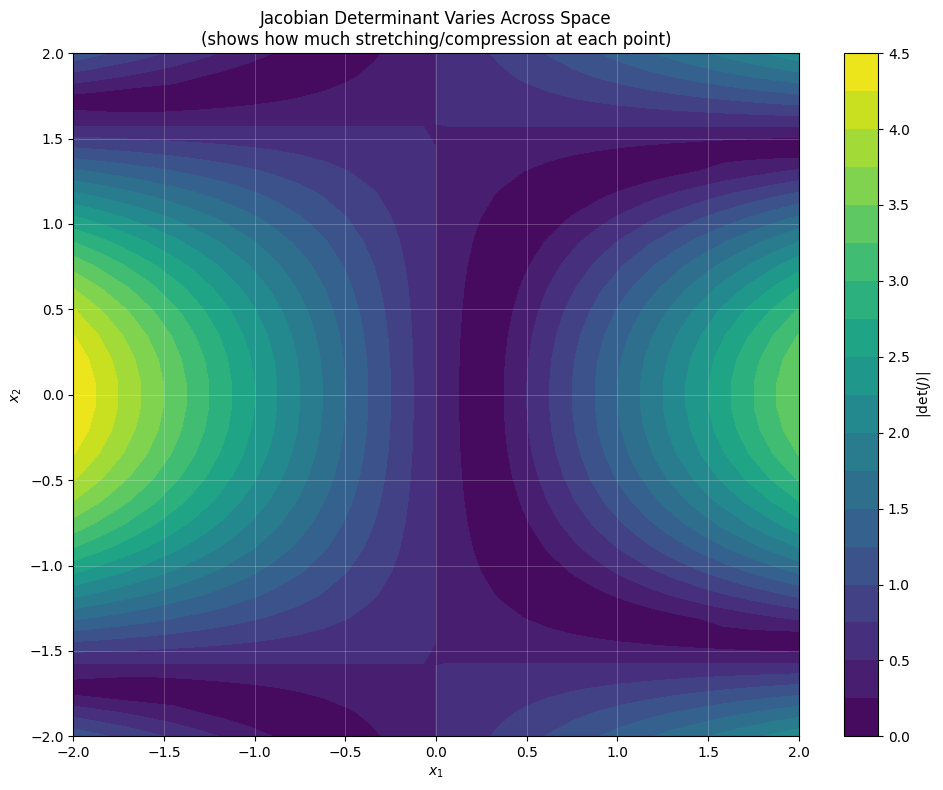

In [29]:
# Define a transformation function
def transform_2d(x):
    """
    A nonlinear transformation: 
    y1 = x1^2 + 0.5*x2
    y2 = x1 + sin(x2)
    """
    y1 = x[:, 0]**2 + 0.5 * x[:, 1]
    y2 = x[:, 0] + torch.sin(x[:, 1])
    return torch.stack([y1, y2], dim=1)

# Function to compute Jacobian determinant using PyTorch
def jacobian_determinant(func, x):
    """
    Compute the Jacobian determinant for a batch of inputs.
    
    Args:
        func: transformation function
        x: input tensor of shape (batch_size, input_dim)
    
    Returns:
        det_J: Jacobian determinants of shape (batch_size,)
    """
    batch_size, input_dim = x.shape
    x_var = x.clone().detach().requires_grad_(True)
    
    # Compute Jacobian for each sample
    jacobians = []
    for i in range(batch_size):
        # Compute Jacobian for single sample
        jac = torch.autograd.functional.jacobian(func, x_var[i:i+1])
        jac = jac.squeeze()  # Remove batch dimensions
        jacobians.append(jac)
    
    jacobians = torch.stack(jacobians)
    
    # Compute determinants
    det_J = torch.det(jacobians)
    return det_J, jacobians

# Visualize how Jacobian determinant varies across space
x1_range = torch.linspace(-2, 2, 30)
x2_range = torch.linspace(-2, 2, 30)
X1, X2 = torch.meshgrid(x1_range, x2_range, indexing='ij')

grid_points = torch.stack([X1.flatten(), X2.flatten()], dim=1)
det_J_grid, _ = jacobian_determinant(transform_2d, grid_points)
det_J_grid = det_J_grid.abs().reshape(X1.shape)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
contour = ax.contourf(X1.numpy(), X2.numpy(), det_J_grid.detach().numpy(), 
                       levels=20, cmap='viridis')
plt.colorbar(contour, ax=ax, label='$|\\det(J)|$')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('Jacobian Determinant Varies Across Space\n(shows how much stretching/compression at each point)')
ax.grid(True, alpha=0.3, color='white', linewidth=0.5)

plt.tight_layout()
plt.show()

Understanding how to compute and interpret Jacobians is useful in many modern machine learning models. The Jacobian determinant tells us the local volume scaling at each point. For nonlinear transformations, this varies across space—some regions expand while others compress.

This is the core principle used in **normalizing flows**: by chaining multiple invertible transformations (each with computable Jacobians), we can transform a simple distribution (like a Gaussian) into arbitrarily complex distributions. The key requirement is that we can compute $|\det(J)|$ efficiently.

Can you think of why we need the transformation to be invertible for normalizing flows? How would you chain multiple transformations together? What happens to the overall Jacobian determinant? (We will revisit these in the relevant generative models chapter.)

## Linear Algebra & Spectral Norms

### Concepts:

- Matrices represent **linear transformations** that stretch, rotate, and compress space
- **Singular values** measure how much a matrix stretches along different directions
- The **spectral norm** (largest singular value) gives the maximum stretching factor
- **Matrix conditioning** (ratio of largest to smallest singular value) indicates numerical stability
- Understanding these geometric properties is essential for analyzing neural networks and optimization

### Key Equations:

**Singular Value Decomposition:**
$$A = U \Sigma V^T$$
where $U, V$ are orthogonal and $\Sigma$ contains singular values $\sigma_1 \geq \sigma_2 \geq \ldots \geq 0$

**Spectral Norm (Matrix 2-norm):**
$$\|A\|_2 = \sigma_{\max}(A) = \max_{\|x\|=1} \|Ax\|$$

**Condition Number:**
$$\kappa(A) = \frac{\sigma_{\max}(A)}{\sigma_{\min}(A)}$$

**Intuition:** The spectral norm tells you "how much can this transformation amplify a vector?" Large spectral norms mean the transformation can greatly magnify small changes in input—this is crucial for understanding gradient flow in deep networks.

### Example: 2D Linear Transform Visualization

Let's see how a matrix transforms space by watching what it does to a regular grid. This gives us intuition for singular values and the spectral norm.

Transformation matrix A:
[[2.  0.5]
 [0.3 1. ]]

Singular values: [2.14364206 0.86301721]
Spectral norm (max singular value): 2.1436
Condition number: 2.4839


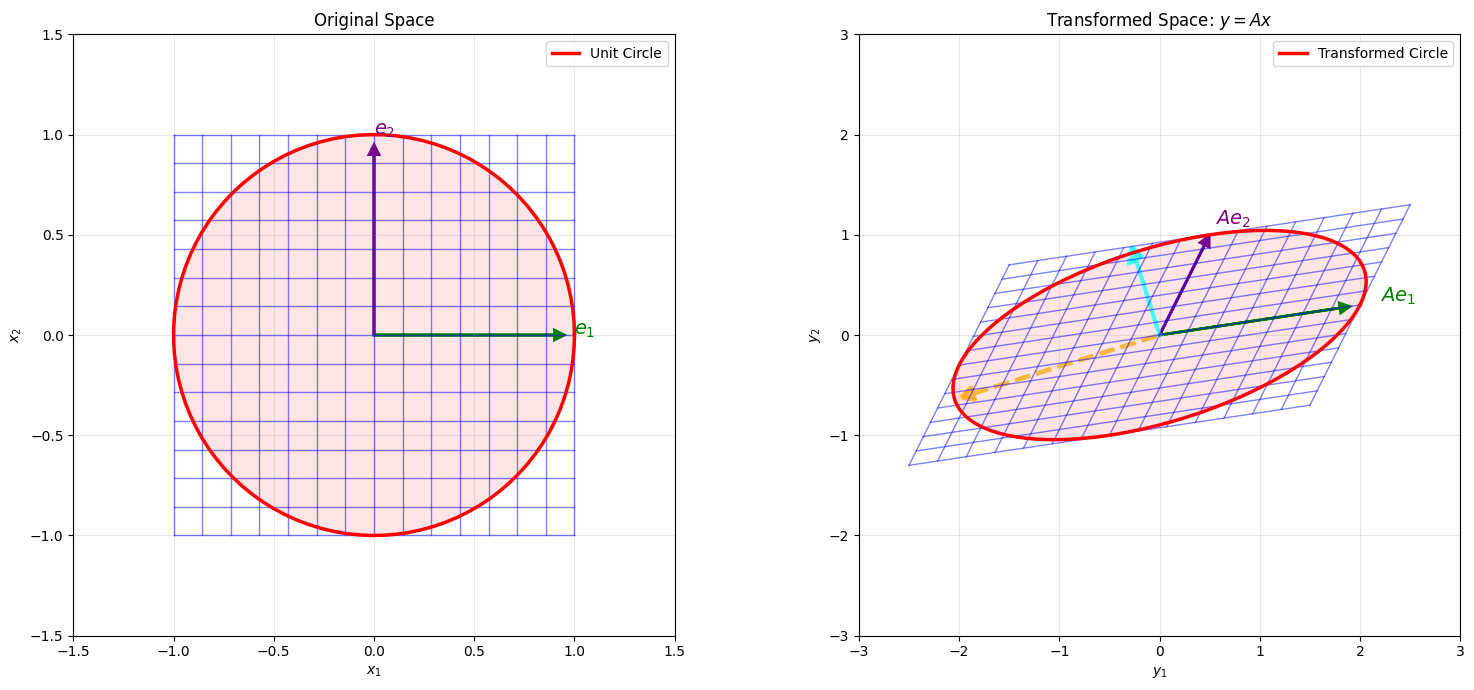

In [31]:
# Create an interesting transformation matrix
# Mix of rotation and stretching
np.random.seed(42)
A = np.array([[2.0, 0.5],
              [0.3, 1.0]])

print("Transformation matrix A:")
print(A)

# Compute SVD
U, singular_values, Vt = np.linalg.svd(A)
print(f"\nSingular values: {singular_values}")
print(f"Spectral norm (max singular value): {singular_values[0]:.4f}")
print(f"Condition number: {singular_values[0]/singular_values[1]:.4f}")

# Create a grid of points
n_grid = 15
x = np.linspace(-1, 1, n_grid)
y = np.linspace(-1, 1, n_grid)
X, Y = np.meshgrid(x, y)

# Create points on grid
points = np.stack([X.ravel(), Y.ravel()], axis=0)

# Apply transformation
transformed_points = A @ points

# Reshape back to grid
X_trans = transformed_points[0, :].reshape(X.shape)
Y_trans = transformed_points[1, :].reshape(Y.shape)

# Create visualization
fig = plt.figure(figsize=(16, 7))

# Left: Original grid
ax1 = fig.add_subplot(121, aspect='equal')
for i in range(n_grid):
    ax1.plot(X[i, :], Y[i, :], 'b-', alpha=0.5, linewidth=1)
    ax1.plot(X[:, i], Y[:, i], 'b-', alpha=0.5, linewidth=1)

# Draw unit circle
theta = np.linspace(0, 2*np.pi, 100)
unit_circle_x = np.cos(theta)
unit_circle_y = np.sin(theta)
ax1.plot(unit_circle_x, unit_circle_y, 'r-', linewidth=2.5, label='Unit Circle')
ax1.fill(unit_circle_x, unit_circle_y, 'red', alpha=0.1)

# Draw coordinate axes
ax1.arrow(0, 0, 0.9, 0, head_width=0.05, head_length=0.05, fc='green', ec='green', linewidth=2)
ax1.arrow(0, 0, 0, 0.9, head_width=0.05, head_length=0.05, fc='purple', ec='purple', linewidth=2)
ax1.text(1.0, 0, '$e_1$', fontsize=14, color='green', fontweight='bold')
ax1.text(0, 1.0, '$e_2$', fontsize=14, color='purple', fontweight='bold')

ax1.set_xlim(-1.5, 1.5)
ax1.set_ylim(-1.5, 1.5)
ax1.set_xlabel('$x_1$')
ax1.set_ylabel('$x_2$')
ax1.set_title('Original Space')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right: Transformed grid
ax2 = fig.add_subplot(122, aspect='equal')
for i in range(n_grid):
    ax2.plot(X_trans[i, :], Y_trans[i, :], 'b-', alpha=0.5, linewidth=1)
    ax2.plot(X_trans[:, i], Y_trans[:, i], 'b-', alpha=0.5, linewidth=1)

# Transform unit circle -> ellipse
ellipse_points = A @ np.stack([unit_circle_x, unit_circle_y])
ax2.plot(ellipse_points[0, :], ellipse_points[1, :], 'r-', linewidth=2.5, 
         label='Transformed Circle')
ax2.fill(ellipse_points[0, :], ellipse_points[1, :], 'red', alpha=0.1)

# Draw transformed coordinate axes
e1_trans = A @ np.array([1, 0])
e2_trans = A @ np.array([0, 1])
ax2.arrow(0, 0, e1_trans[0]*0.9, e1_trans[1]*0.9, 
          head_width=0.1, head_length=0.1, fc='green', ec='green', linewidth=2)
ax2.arrow(0, 0, e2_trans[0]*0.9, e2_trans[1]*0.9, 
          head_width=0.1, head_length=0.1, fc='purple', ec='purple', linewidth=2)
ax2.text(e1_trans[0]*1.1, e1_trans[1]*1.1, '$Ae_1$', 
         fontsize=14, color='green', fontweight='bold')
ax2.text(e2_trans[0]*1.1, e2_trans[1]*1.1, '$Ae_2$', 
         fontsize=14, color='purple', fontweight='bold')

# Draw singular vectors
# Right singular vectors (V) point in direction of maximum stretch
# Left singular vectors (U) point in direction of output
v1 = Vt[0, :]  # Direction of max stretch in input
v2 = Vt[1, :]  # Direction of min stretch in input
u1 = U[:, 0]   # Direction in output
u2 = U[:, 1]

# Draw principal directions in transformed space
sigma1_vec = singular_values[0] * u1
sigma2_vec = singular_values[1] * u2
ax2.arrow(0, 0, sigma1_vec[0]*0.9, sigma1_vec[1]*0.9, 
          head_width=0.15, head_length=0.15, fc='orange', ec='orange', 
          linewidth=3, alpha=0.7, linestyle='--')
ax2.arrow(0, 0, sigma2_vec[0]*0.9, sigma2_vec[1]*0.9, 
          head_width=0.15, head_length=0.15, fc='cyan', ec='cyan', 
          linewidth=3, alpha=0.7, linestyle='--')

ax2.set_xlim(-3, 3)
ax2.set_ylim(-3, 3)
ax2.set_xlabel('$y_1$')
ax2.set_ylabel('$y_2$')
ax2.set_title('Transformed Space: $y = Ax$')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The transformation turns a circle into an ellipse. The singular values tell us exactly how much the matrix stretches in its principal directions. The spectral norm is the maximum stretching factor, which in the above example is 2.1436 and the same as the ellipse's semi-major axis length, with 0.863 being the semi-minor axis length. This is crucial for understanding how errors propagate through linear transformations. For example, in deep learning, if weight matrices have large spectral norms, small input perturbations can get amplified dramatically. What problems do you think this might cause?

### Example: Spectral Norms and Condition Numbers of Different Matrices

Let's explore how different matrices have different spectral properties and what that means for numerical stability.

In [32]:
# code-fold: false
# Create different types of matrices
matrices = {
    'Well-conditioned': np.array([[1.0, 0.2], [0.2, 1.0]]),
    'Stretched': np.array([[5.0, 0.0], [0.0, 1.0]]),
    'Ill-conditioned': np.array([[10.0, 9.99], [9.99, 10.0]]),
    'Nearly singular': np.array([[1.0, 1.0], [1.0, 1.001]])
}

# Analyze each matrix
results = {}
for name, A in matrices.items():
    U, s, Vt = np.linalg.svd(A)
    spectral_norm = s[0]
    condition_number = s[0] / s[1] if s[1] > 1e-10 else np.inf
    det_A = np.linalg.det(A)
    results[name] = {
        'A': A,
        'singular_values': s,
        'spectral_norm': spectral_norm,
        'condition_number': condition_number,
        'determinant': det_A,
        'U': U,
        'Vt': Vt
    }


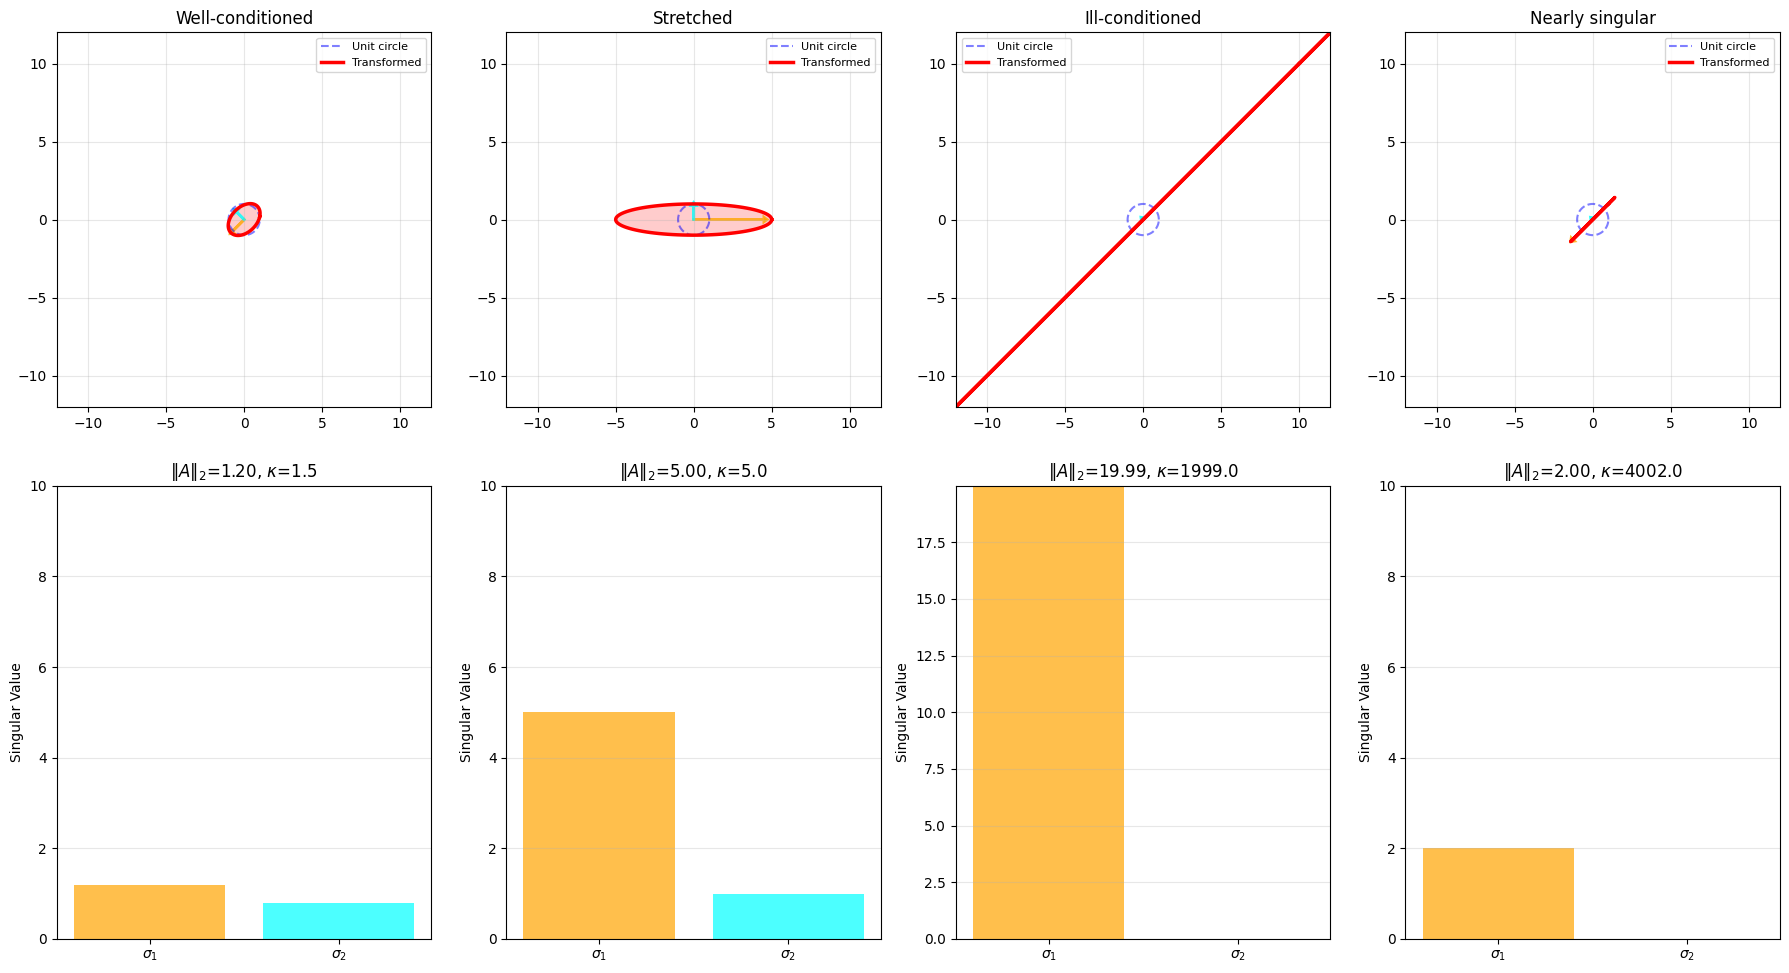

Matrix Analysis Summary
Name                 ‖A‖₂         κ(A)            det(A)      
--------------------------------------------------------------------------------
Well-conditioned     1.2000       1.50            0.960000    
Stretched            5.0000       5.00            5.000000    
Ill-conditioned      19.9900      1999.00         0.199900    
Nearly singular      2.0005       4002.00         0.001000    


In [34]:

# Create visualization
fig, axes = plt.subplots(2, 4, figsize=(18, 10))

for idx, (name, info) in enumerate(results.items()):
    # Top row: transformed unit circle
    ax_circle = axes[0, idx]
    
    # Draw unit circle
    theta = np.linspace(0, 2*np.pi, 100)
    circle = np.stack([np.cos(theta), np.sin(theta)])
    
    # Transform circle
    ellipse = info['A'] @ circle
    
    ax_circle.plot(circle[0, :], circle[1, :], 'b--', linewidth=1.5, 
                   alpha=0.5, label='Unit circle')
    ax_circle.plot(ellipse[0, :], ellipse[1, :], 'r-', linewidth=2.5, 
                   label='Transformed')
    ax_circle.fill(ellipse[0, :], ellipse[1, :], 'red', alpha=0.2)
    
    # Draw singular value directions
    s = info['singular_values']
    U = info['U']
    ax_circle.arrow(0, 0, s[0]*U[0,0]*0.9, s[0]*U[1,0]*0.9,
                    head_width=0.3, head_length=0.2, fc='orange', ec='orange',
                    linewidth=2, alpha=0.8)
    ax_circle.arrow(0, 0, s[1]*U[0,1]*0.9, s[1]*U[1,1]*0.9,
                    head_width=0.3, head_length=0.2, fc='cyan', ec='cyan',
                    linewidth=2, alpha=0.8)
    
    ax_circle.set_aspect('equal')
    ax_circle.grid(True, alpha=0.3)
    ax_circle.set_title(name)
    ax_circle.legend(fontsize=8)
    ax_circle.set_xlim(-12, 12)
    ax_circle.set_ylim(-12, 12)
    
    # Bottom row: Singular value bar chart
    ax_sv = axes[1, idx]
    ax_sv.bar(['$\\sigma_1$', '$\\sigma_2$'], s, color=['orange', 'cyan'], alpha=0.7)
    ax_sv.set_ylabel('Singular Value')
    ax_sv.set_title(f'$\\|A\\|_2$={info["spectral_norm"]:.2f}, $\\kappa$={info["condition_number"]:.1f}')
    ax_sv.grid(True, alpha=0.3, axis='y')
    ax_sv.set_ylim(0, max(s[0], 10))

plt.tight_layout()
plt.show()

# Print detailed comparison
print("Matrix Analysis Summary")
print("=" * 80)
print(f"{'Name':<20} {'‖A‖₂':<12} {'κ(A)':<15} {'det(A)':<12}")
print("-" * 80)

for name, info in results.items():
    spec_norm = info['spectral_norm']
    cond_num = info['condition_number']
    det_val = info['determinant']
    print(f"{name:<20} {spec_norm:<12.4f} {cond_num:<15.2f} {det_val:<12.6f}")

We see that for well-conditioned matrices, they have a small condition number that barely amplifies or stretches the origina data. As we increase the condition number, small perturbations in the input can cause large changes in the output matrix. However, even if the spectral norm is small, the matrix can still have a large condition number, which can make the matrix difficult to invert or compute stable gradients with respect to.

### Example: Neural Network Jacobian and Local Geometry

Neural networks are compositions of nonlinear transformations. At any point, the local behavior is captured by the Jacobian matrix. Let's visualize how a simple neural network transforms space locally.

In [37]:
#| code-fold: false
# Define a simple 2-layer neural network: R^2 -> R^2
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 8, bias=True)
        self.fc2 = nn.Linear(8, 2, bias=True)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize network with specific seed
torch.manual_seed(42)
net = SimpleNet()

# Function to compute Jacobian at a point
def compute_jacobian(model, x):
    """Compute Jacobian matrix of model output w.r.t. input at point x"""
    x_tensor = torch.tensor(x, dtype=torch.float32, requires_grad=True)
    y = model(x_tensor.unsqueeze(0))
    
    jacobian = []
    for i in range(y.shape[1]):
        grad = torch.autograd.grad(y[0, i], x_tensor, 
                                   create_graph=True, retain_graph=True)[0]
        jacobian.append(grad.detach().numpy())
    
    return np.array(jacobian)

# Visualize transformation at different points in space
test_points = [
    np.array([0.0, 0.0]),
    np.array([1.0, 1.0]),
    np.array([-1.0, 0.5]),
]

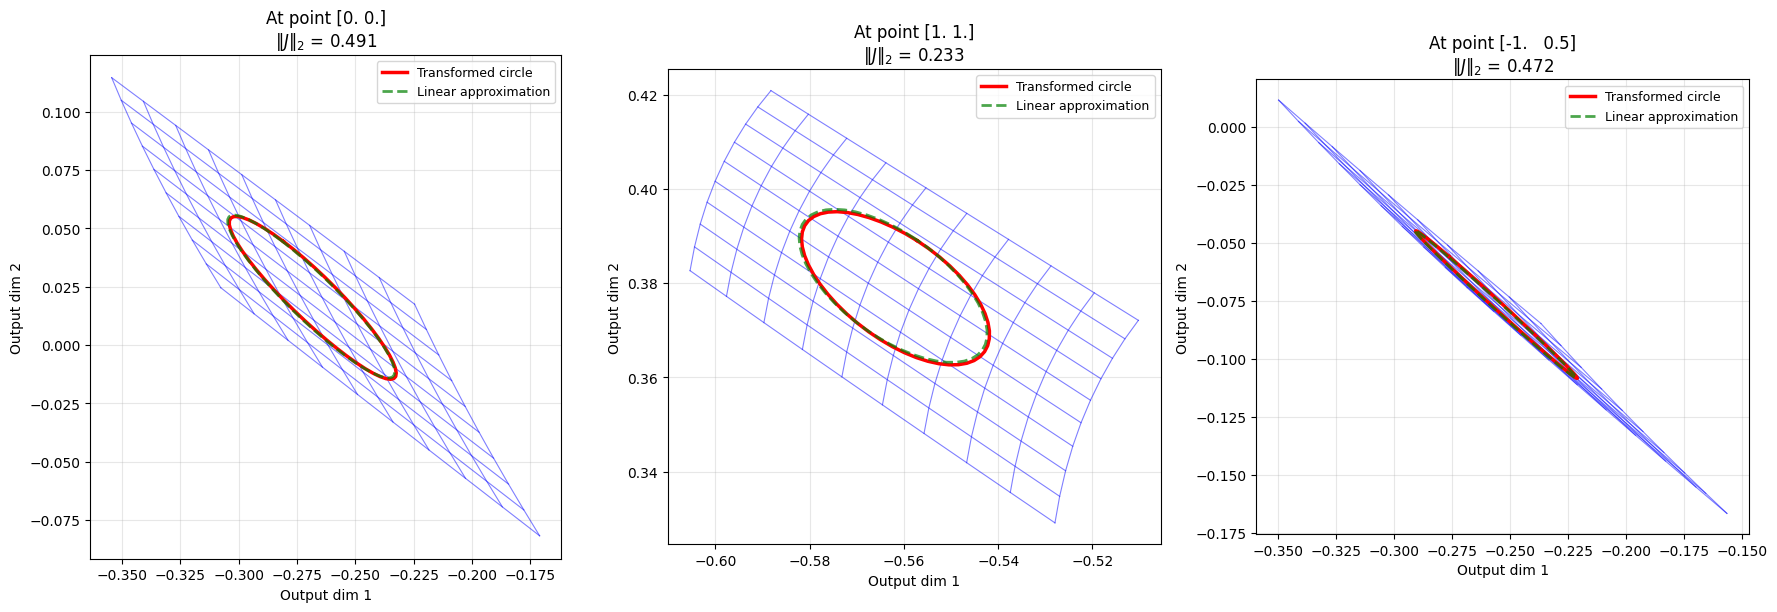


At point [0. 0.]:
Jacobian matrix:
[[-0.12561867 -0.3354176 ]
 [ 0.23783804  0.2557892 ]]
Singular values: [0.4907707  0.09707827]
Spectral norm: 0.4908
Condition number: 5.0554

At point [1. 1.]:
Jacobian matrix:
[[ 0.04538195 -0.19429947]
 [ 0.10090272  0.12735607]]
Singular values: [0.23314807 0.10887937]
Spectral norm: 0.2331
Condition number: 2.1413

At point [-1.   0.5]:
Jacobian matrix:
[[-0.20401104 -0.28298327]
 [ 0.20504908  0.24390957]]
Singular values: [0.47215527 0.01750529]
Spectral norm: 0.4722
Condition number: 26.9721


In [38]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, point in enumerate(test_points):
    ax = axes[idx]
    
    # Compute Jacobian at this point
    J = compute_jacobian(net, point)
    
    # Compute singular values
    U, s, Vt = np.linalg.svd(J)
    spectral_norm = s[0]
    
    # Create a small grid around the point
    delta = 0.2
    n_grid = 10
    x_local = np.linspace(-delta, delta, n_grid)
    y_local = np.linspace(-delta, delta, n_grid)
    X_local, Y_local = np.meshgrid(x_local, y_local)
    
    # Transform grid through network
    grid_points = np.stack([X_local.ravel() + point[0], 
                           Y_local.ravel() + point[1]], axis=0)
    
    with torch.no_grad():
        grid_tensor = torch.tensor(grid_points.T, dtype=torch.float32)
        transformed = net(grid_tensor).numpy()
    
    X_trans = transformed[:, 0].reshape(X_local.shape)
    Y_trans = transformed[:, 1].reshape(Y_local.shape)
    
    # Plot transformed grid
    for i in range(n_grid):
        ax.plot(X_trans[i, :], Y_trans[i, :], 'b-', alpha=0.5, linewidth=0.8)
        ax.plot(X_trans[:, i], Y_trans[:, i], 'b-', alpha=0.5, linewidth=0.8)
    
    # Draw a small circle around the point and its transformation
    theta = np.linspace(0, 2*np.pi, 50)
    radius = 0.1
    circle = radius * np.stack([np.cos(theta), np.sin(theta)])
    circle_centered = circle + point[:, np.newaxis]
    
    with torch.no_grad():
        circle_tensor = torch.tensor(circle_centered.T, dtype=torch.float32)
        circle_transformed = net(circle_tensor).numpy()
    
    ax.plot(circle_transformed[:, 0], circle_transformed[:, 1], 'r-', 
            linewidth=2.5, label='Transformed circle')
    
    # Draw ellipse predicted by linear approximation (Jacobian)
    # Transform centered circle with Jacobian, then translate
    with torch.no_grad():
        point_tensor = torch.tensor(point, dtype=torch.float32).unsqueeze(0)
        center_transformed = net(point_tensor).numpy()[0]
    
    ellipse_linear = J @ circle + center_transformed[:, np.newaxis]
    ax.plot(ellipse_linear[0, :], ellipse_linear[1, :], 'g--', 
            linewidth=2, label='Linear approximation', alpha=0.7)
    
    ax.set_aspect('equal')
    ax.set_title(f'At point {point}\n$\\|J\\|_2$ = {spectral_norm:.3f}')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('Output dim 1')
    ax.set_ylabel('Output dim 2')

plt.tight_layout()
plt.show()

# Print Jacobian analysis
for point in test_points:
    J = compute_jacobian(net, point)
    U, s, Vt = np.linalg.svd(J)
    
    print(f"\nAt point {point}:")
    print("Jacobian matrix:")
    print(J)
    print(f"Singular values: {s}")
    print(f"Spectral norm: {s[0]:.4f}")
    print(f"Condition number: {s[0]/s[1]:.4f}")

We can see that the neural network's Jacobian is changing across the input space. The Jacobian tells us how the neural network behaves locally—like a linear approximation at each point. The red curve shows the actual transformation of a small circle, while the green dashed line shows what the Jacobian predicts. When they match well, the network is locally linear; when they diverge, the nonlinearity is strong.

### Example: Spectral Normalization

Spectral normalization is a technique to control the Lipschitz constant of neural networks by constraining weight matrices to have spectral norm $\leq 1$. Let's see how this affects the transformation.

In [39]:
#| code-fold: false
# Function to apply spectral normalization to a weight matrix
def spectral_normalize(W, n_iterations=1):
    """
    Normalize a weight matrix so its spectral norm is 1.
    Uses power iteration to estimate the largest singular value.
    """
    U, s, Vt = np.linalg.svd(W, full_matrices=False)
    sigma_max = s[0]
    return W / sigma_max, sigma_max

# Create two versions of a weight matrix
np.random.seed(42)
W_original = np.random.randn(2, 2) * 2  # Scaled up for effect

# Apply spectral normalization
W_normalized, original_spectral_norm = spectral_normalize(W_original)

Original weight matrix:
[[ 0.99342831 -0.2765286 ]
 [ 1.29537708  3.04605971]]
Spectral norm: 3.3131

Spectral normalized weight matrix:
[[ 0.29985151 -0.08346603]
 [ 0.39099024  0.91940767]]
Spectral norm: 1.0000


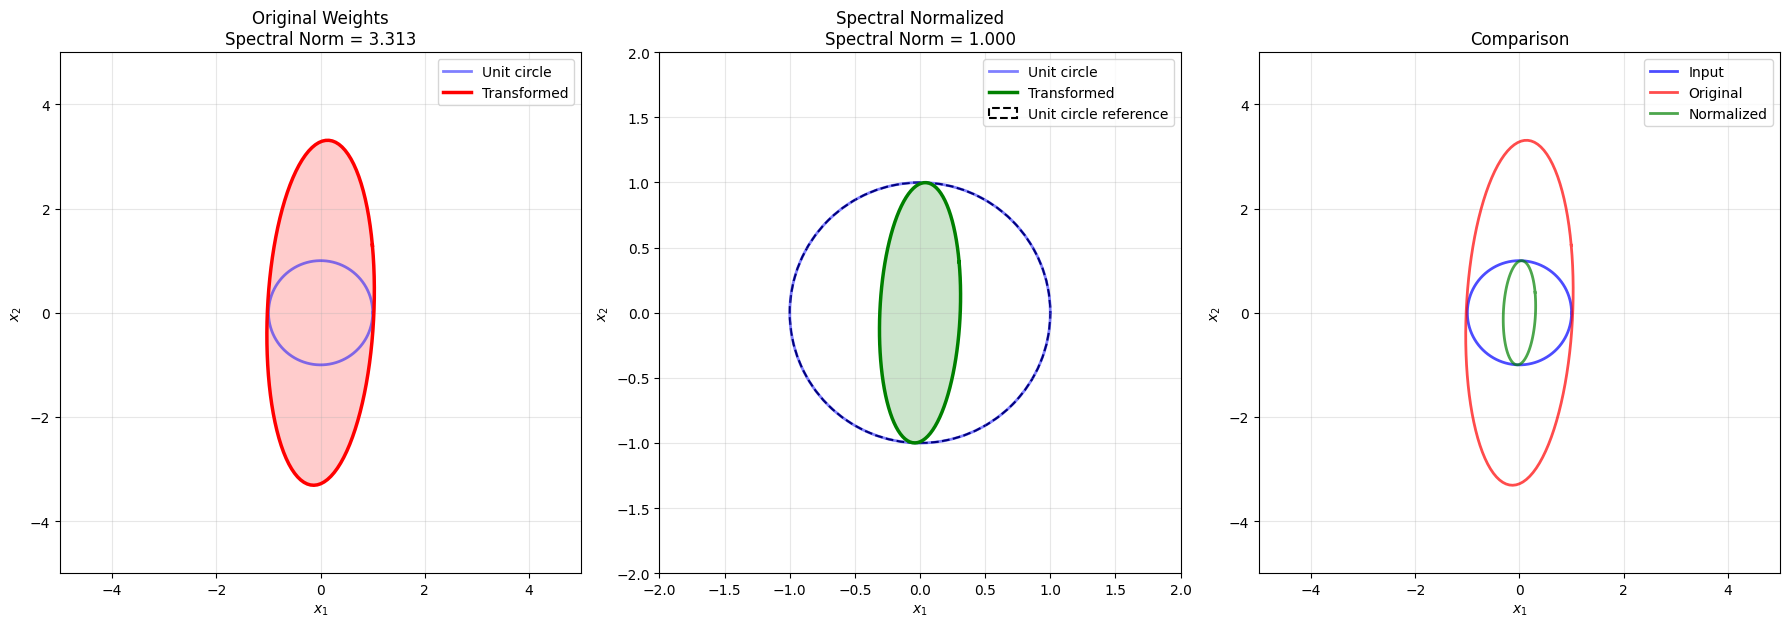

In [43]:
print("Original weight matrix:")
print(W_original)
print(f"Spectral norm: {original_spectral_norm:.4f}")

print("\nSpectral normalized weight matrix:")
print(W_normalized)
print(f"Spectral norm: {np.linalg.svd(W_normalized, compute_uv=False)[0]:.4f}")

# Visualize the effect on unit circle
theta = np.linspace(0, 2*np.pi, 100)
unit_circle = np.stack([np.cos(theta), np.sin(theta)])

transformed_original = W_original @ unit_circle
transformed_normalized = W_normalized @ unit_circle

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Left: Original transformation
ax = axes[0]
ax.plot(unit_circle[0, :], unit_circle[1, :], 'b-', linewidth=2, 
        label='Unit circle', alpha=0.5)
ax.plot(transformed_original[0, :], transformed_original[1, :], 'r-', 
        linewidth=2.5, label='Transformed')
ax.fill(transformed_original[0, :], transformed_original[1, :], 'red', alpha=0.2)
ax.set_aspect('equal')
ax.set_title(f'Original Weights\nSpectral Norm = {original_spectral_norm:.3f}')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

# Middle: Normalized transformation
ax = axes[1]
ax.plot(unit_circle[0, :], unit_circle[1, :], 'b-', linewidth=2, 
        label='Unit circle', alpha=0.5)
ax.plot(transformed_normalized[0, :], transformed_normalized[1, :], 'g-', 
        linewidth=2.5, label='Transformed')
ax.fill(transformed_normalized[0, :], transformed_normalized[1, :], 'green', alpha=0.2)

# Draw unit circle as reference
circle_ref = plt.Circle((0, 0), 1, fill=False, color='black', 
                        linestyle='--', linewidth=1.5, label='Unit circle reference')
ax.add_patch(circle_ref)

ax.set_aspect('equal')
ax.set_title('Spectral Normalized\nSpectral Norm = 1.000')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

# Right: Comparison
ax = axes[2]
ax.plot(unit_circle[0, :], unit_circle[1, :], 'b-', linewidth=2, 
        label='Input', alpha=0.7)
ax.plot(transformed_original[0, :], transformed_original[1, :], 'r-', 
        linewidth=2, label='Original', alpha=0.7)
ax.plot(transformed_normalized[0, :], transformed_normalized[1, :], 'g-', 
        linewidth=2, label='Normalized', alpha=0.7)
ax.set_aspect('equal')
ax.set_title('Comparison')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

plt.tight_layout()
plt.show()

Spectral normalization ensures that no input vector gets amplified by more than a factor of 1. This is useful for training stability in deep networks since repeated multiplications by weight matrices with large spectral norms can cause gradients to explode. It can also have benefits in cases where we might wish to bound the amount that a given input perturbation can affect a network (e.g., for adversarial robustness).

## Differentiation & Curvature

### Concepts:

- **Gradients** point in the direction of steepest ascent and guide first-order optimization
- **Hessians** capture curvature (second-order information) about the function's shape
- **Jacobian-vector products (JVPs)** and **Hessian-vector products (HVPs)** allow efficient computation without forming full matrices
- Curvature determines optimization difficulty: flat regions are slow, steep valleys cause oscillation
- Understanding higher-order structure is useful for advanced optimization and model analysis

### Key Equations:

**Gradient (First derivative):**
$$\nabla f(x) = \begin{bmatrix} \frac{\partial f}{\partial x_1} \\ \vdots \\ \frac{\partial f}{\partial x_n} \end{bmatrix}$$

**Hessian (Second derivative matrix):**
$$H(f)(x) = \begin{bmatrix} \frac{\partial^2 f}{\partial x_i \partial x_j} \end{bmatrix}$$

**Intuition:** The gradient tells you which way is "downhill," but the Hessian tells you how quickly the slope is changing. Various optimizers like Newton's method or L-BFGS can use curvature to take smarter steps than simple gradient descent.

### Example: Gradient and Hessian Visualization

Let's visualize how the gradient (slope) and Hessian (curvature) change at different points along a function. We'll use $f(x) = x^3 - 3x$ and detect different gradient and curvature regions.

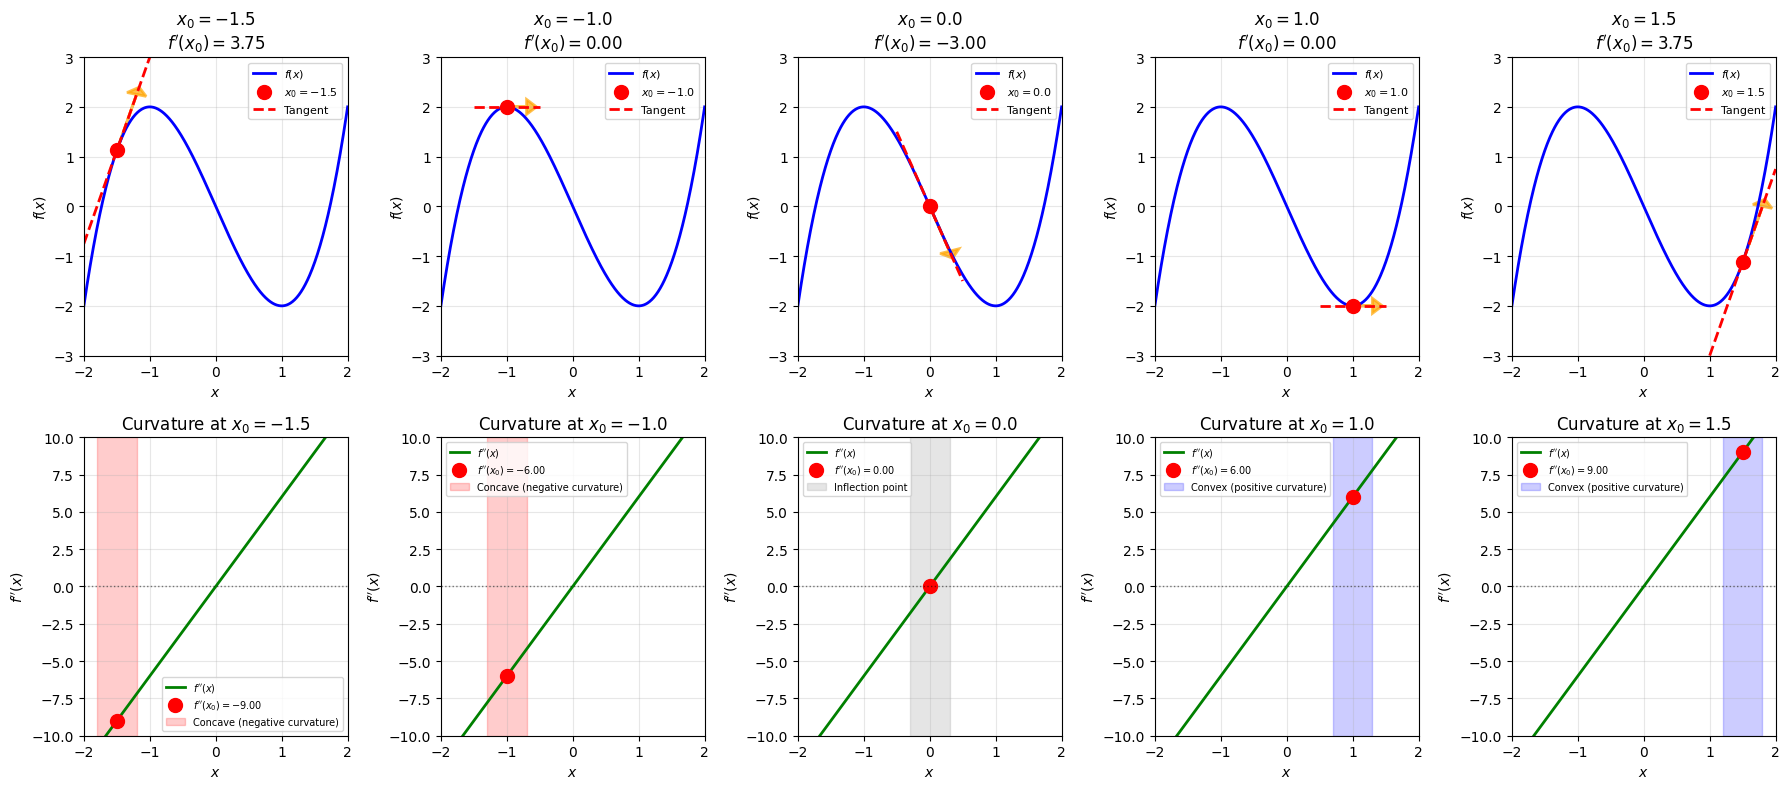

In [44]:
# Define function and its derivatives
def f(x):
    """f(x) = x^3 - 3x"""
    return x**3 - 3*x

def f_prime(x):
    """First derivative: f'(x) = 3x^2 - 3"""
    return 3*x**2 - 3

def f_double_prime(x):
    """Second derivative: f''(x) = 6x"""
    return 6*x

# Points to analyze
test_points = [-1.5, -1.0, 0.0, 1.0, 1.5]

# Create grid for plotting
x_grid = np.linspace(-2, 2, 500)
y_grid = f(x_grid)

# Create visualization
fig, axes = plt.subplots(2, len(test_points), figsize=(18, 8))

for idx, x0 in enumerate(test_points):
    # Compute derivatives at x0
    y0 = f(x0)
    gradient = f_prime(x0)
    hessian = f_double_prime(x0)
    
    # Top row: Function with tangent line
    ax_top = axes[0, idx]
    ax_top.plot(x_grid, y_grid, 'b-', linewidth=2, label='$f(x)$')
    ax_top.plot(x0, y0, 'ro', markersize=10, label=f'$x_0={x0}$')
    
    # Draw tangent line
    tangent_x = np.linspace(x0 - 0.5, x0 + 0.5, 100)
    tangent_y = y0 + gradient * (tangent_x - x0)
    ax_top.plot(tangent_x, tangent_y, 'r--', linewidth=2, label='Tangent')
    
    # Draw gradient arrow
    arrow_scale = 0.3
    ax_top.arrow(x0, y0, arrow_scale, gradient * arrow_scale,
                 head_width=0.3, head_length=0.15, fc='orange', ec='orange',
                 linewidth=2, alpha=0.7)
    
    ax_top.set_xlabel('$x$')
    ax_top.set_ylabel('$f(x)$')
    ax_top.set_title(f'$x_0 = {x0}$\n$f\'(x_0) = {gradient:.2f}$')
    ax_top.legend(fontsize=8)
    ax_top.grid(True, alpha=0.3)
    ax_top.set_xlim(-2, 2)
    ax_top.set_ylim(-3, 3)
    
    # Bottom row: Second derivative (curvature)
    ax_bottom = axes[1, idx]
    ax_bottom.plot(x_grid, f_double_prime(x_grid), 'g-', linewidth=2, label='$f\'\'(x)$')
    ax_bottom.plot(x0, hessian, 'ro', markersize=10, label=f'$f\'\'(x_0)={hessian:.2f}$')
    ax_bottom.axhline(0, color='black', linestyle=':', linewidth=1, alpha=0.5)
    
    # Shade regions
    if hessian > 0:
        ax_bottom.axvspan(x0 - 0.3, x0 + 0.3, alpha=0.2, color='blue', 
                          label='Convex (positive curvature)')
    elif hessian < 0:
        ax_bottom.axvspan(x0 - 0.3, x0 + 0.3, alpha=0.2, color='red',
                          label='Concave (negative curvature)')
    else:
        ax_bottom.axvspan(x0 - 0.3, x0 + 0.3, alpha=0.2, color='gray',
                          label='Inflection point')
    
    ax_bottom.set_xlabel('$x$')
    ax_bottom.set_ylabel('$f\'\'(x)$')
    ax_bottom.set_title(f'Curvature at $x_0 = {x0}$')
    ax_bottom.legend(fontsize=7)
    ax_bottom.grid(True, alpha=0.3)
    ax_bottom.set_xlim(-2, 2)
    ax_bottom.set_ylim(-10, 10)

plt.tight_layout()
plt.show()

The gradient tells you the instantaneous rate of change (the slope of the tangent line), while the Hessian tells you how fast that slope is changing (the curvature). When the Hessian is positive, the function curves upward like a bowl—this is where gradient descent naturally converges. When it's negative, the function curves downward—a local maximum. At the inflection point (x=0), the curvature is zero.

### Example: Reducing Computational Cost using JVPs and HVPs

Jacobian-vector products (JVPs) and Hessian-vector products (HVPs) let us compute directional derivatives efficiently without forming the full Jacobian or Hessian matrix. This is crucial for large-scale problems. We will first see how this works on a simple 2D function, and then later move to a more realistic case of a Neural Network.

In [57]:
#| code-fold: false
# A simple 2D function f(x, y)
def f(xy):
    x, y = xy[..., 0], xy[..., 1]
    return (x**2 + y**2) + 0.5 * x * y**3

xy = torch.tensor([1.0, 2.0], requires_grad=True)
f_val = f(xy)

# Gradient (Jacobian of f wrt xy)
# create_graph=True so we can differentiate the gradient later
grad = torch.autograd.grad(f_val, xy, create_graph=True)[0]
print("Gradient:", grad)

# Choose a direction vector v (match dtype/device of xy)
v = torch.tensor([1.0, -0.5], dtype=xy.dtype, device=xy.device)

# Directional derivative (scalar): ∇f(x) · v
jvp_scalar = (grad * v).sum()
print("Directional derivative (∇f · v):", jvp_scalar.item())

# Hessian-vector product: H·v = ∇_x (∇f · v)
hvp = torch.autograd.grad(jvp_scalar, xy)[0]
print("Hessian-Vector Product (H·v):", hvp)

Gradient: tensor([ 6., 10.], grad_fn=<AddBackward0>)
Directional derivative (∇f · v): 1.0
Hessian-Vector Product (H·v): tensor([-1.,  2.])


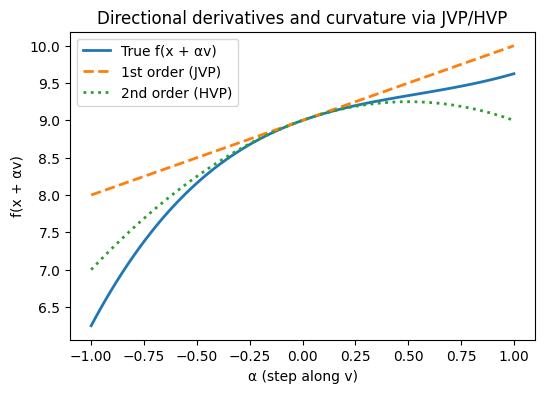

In [58]:
# Sweep along direction v
alphas = torch.linspace(-1, 1, 100)
points = xy + alphas[:, None] * v
f_vals = torch.stack([f(p) for p in points]).detach()

# First and second order Taylor approximations
f0 = f_val.detach()
grad_v = (grad @ v).detach()
curv_v = (v @ hvp).detach()

f_linear = f0 + alphas * grad_v
f_quadratic = f0 + alphas * grad_v + 0.5 * (alphas**2) * curv_v

plt.figure(figsize=(6,4))
plt.plot(alphas, f_vals, label="True f(x + αv)")
plt.plot(alphas, f_linear, '--', label="1st order (JVP)")
plt.plot(alphas, f_quadratic, ':', label="2nd order (HVP)")
plt.xlabel("α (step along v)")
plt.ylabel("f(x + αv)")
plt.legend()
plt.title("Directional derivatives and curvature via JVP/HVP")
plt.show()

Now let's show how this might be useful in a Neural Network context:

In [69]:
#| code-fold: false
# Small network: 2 inputs → 4 hidden → 1 output
net = nn.Sequential(
    nn.Linear(2, 4),
    nn.Tanh(),
    nn.Linear(4, 1)
)

# Make output scalar to ensure gradients are well-defined for higher-order derivatives
x = torch.randn(1, 2)
y = net(x).sum()  # sum to scalar

# Collect parameters
params = [p for p in net.parameters() if p.requires_grad]

# First-order gradients (create_graph=True so we can compute higher-order derivatives)
grads = torch.autograd.grad(y, params, create_graph=True)

# Random direction in parameter space
v = [torch.randn_like(p) for p in params]

# Compute JVP contributions per-parameter (these are tensors shaped like each parameter)
jvp_per_param = [g * vi for g, vi in zip(grads, v)]

# Scalar directional derivative (sum over all parameters) = (∂y/∂θ) · v
jvp_scalar = sum((jp).sum() for jp in jvp_per_param)

# Hessian-vector product H·v computed as gradient of the scalar jvp_scalar w.r.t. params
# allow_unused=True may return None for parameters that did not contribute to jvp_scalar
hvp = torch.autograd.grad(jvp_scalar, params, retain_graph=True, allow_unused=True)

In [70]:
# Report norms (handle possible None entries safely)
for i, (p, j_contrib, h) in enumerate(zip(params, jvp_per_param, hvp)):
    # j_contrib is the per-parameter contribution to the JVP; take its norm if available
    try:
        j_norm = j_contrib.norm().item() if j_contrib is not None else float('nan')
    except Exception:
        j_norm = float('nan')
    # h may be None if the corresponding parameter did not affect jvp_scalar
    try:
        h_norm = h.norm().item() if (h is not None and isinstance(h, torch.Tensor)) else float('nan')
    except Exception:
        h_norm = float('nan')
    print(f"Layer {i} | Param shape {tuple(p.shape)} | JVP contrib norm={j_norm:.3f} | HVP norm={h_norm:.3f}")

Layer 0 | Param shape (4, 2) | JVP contrib norm=0.246 | HVP norm=2.030
Layer 1 | Param shape (4,) | JVP contrib norm=0.176 | HVP norm=1.066
Layer 2 | Param shape (1, 4) | JVP contrib norm=1.220 | HVP norm=0.983
Layer 3 | Param shape (1,) | JVP contrib norm=0.027 | HVP norm=nan


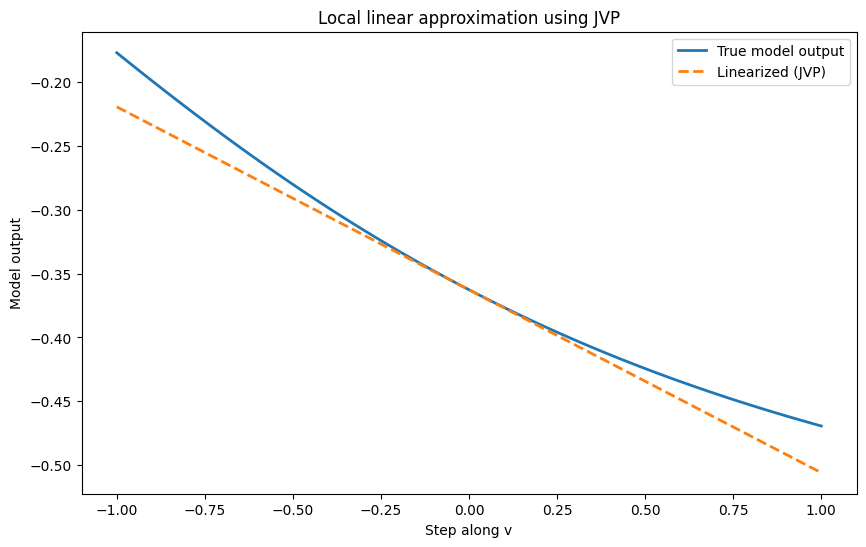

In [71]:
# Visualize how the output changes along an input direction
model = net
x = torch.randn(1, 2, requires_grad=True)
y = model(x)

v = torch.tensor([[1.0, 0.0]])
y_val, jvp = torch.autograd.functional.jvp(model, x, v)

alphas = torch.linspace(-1, 1, 100).unsqueeze(1)
outputs = [model(x + α*v).item() for α in alphas]
plt.plot(alphas, outputs, label="True model output")
plt.plot(alphas, y_val.item() + alphas*jvp.item(), '--', label="Linearized (JVP)")
plt.xlabel("Step along v")
plt.ylabel("Model output")
plt.title("Local linear approximation using JVP")
plt.legend()
plt.show()


The full Hessian of a neural network with $p$ parameters is a $p \times p$ matrix, and for modern networks with millions of parameters, this is completely infeasible. JVPs and HVPs give us access to gradient and curvature information, respectively. along specific directions at a fraction of the cost.

## Marginalization of Probability Distributions

### Concepts:

- **Joint distributions** $p(x, z)$ describe the probability of multiple variables together
- **Marginal distributions** $p(x)$ are obtained by integrating (or summing) out other variables
- Marginalization is fundamental to probabilistic inference and latent variable models
- For continuous variables: $p(x) = \int p(x, z) dz$
- For discrete variables: $p(x) = \sum_z p(x, z)$
- This operation removes nuisance variables and reveals the distribution of the variable we care about

### Key Equations:

**Marginalization (continuous):**
$$p(x) = \int p(x, z) \, dz$$

**Law of Total Probability:**
$$p(x) = \int p(x | z) p(z) \, dz = \mathbb{E}_Z[p(x|Z)]$$

**Conditional Distribution:**
$$p(x | z) = \frac{p(x, z)}{p(z)}$$

**Intuition:** Marginalization asks "what's the probability of $x$, averaging over all possible values of $z$?" It's like projecting a 2D distribution onto a 1D axis: you're summing up all the probability mass along one direction.

### Example: 2D Gaussian Marginalization

Let's visualize a 2D Gaussian distribution and see what happens when we marginalize out one variable. This is the foundation for understanding latent variable models.

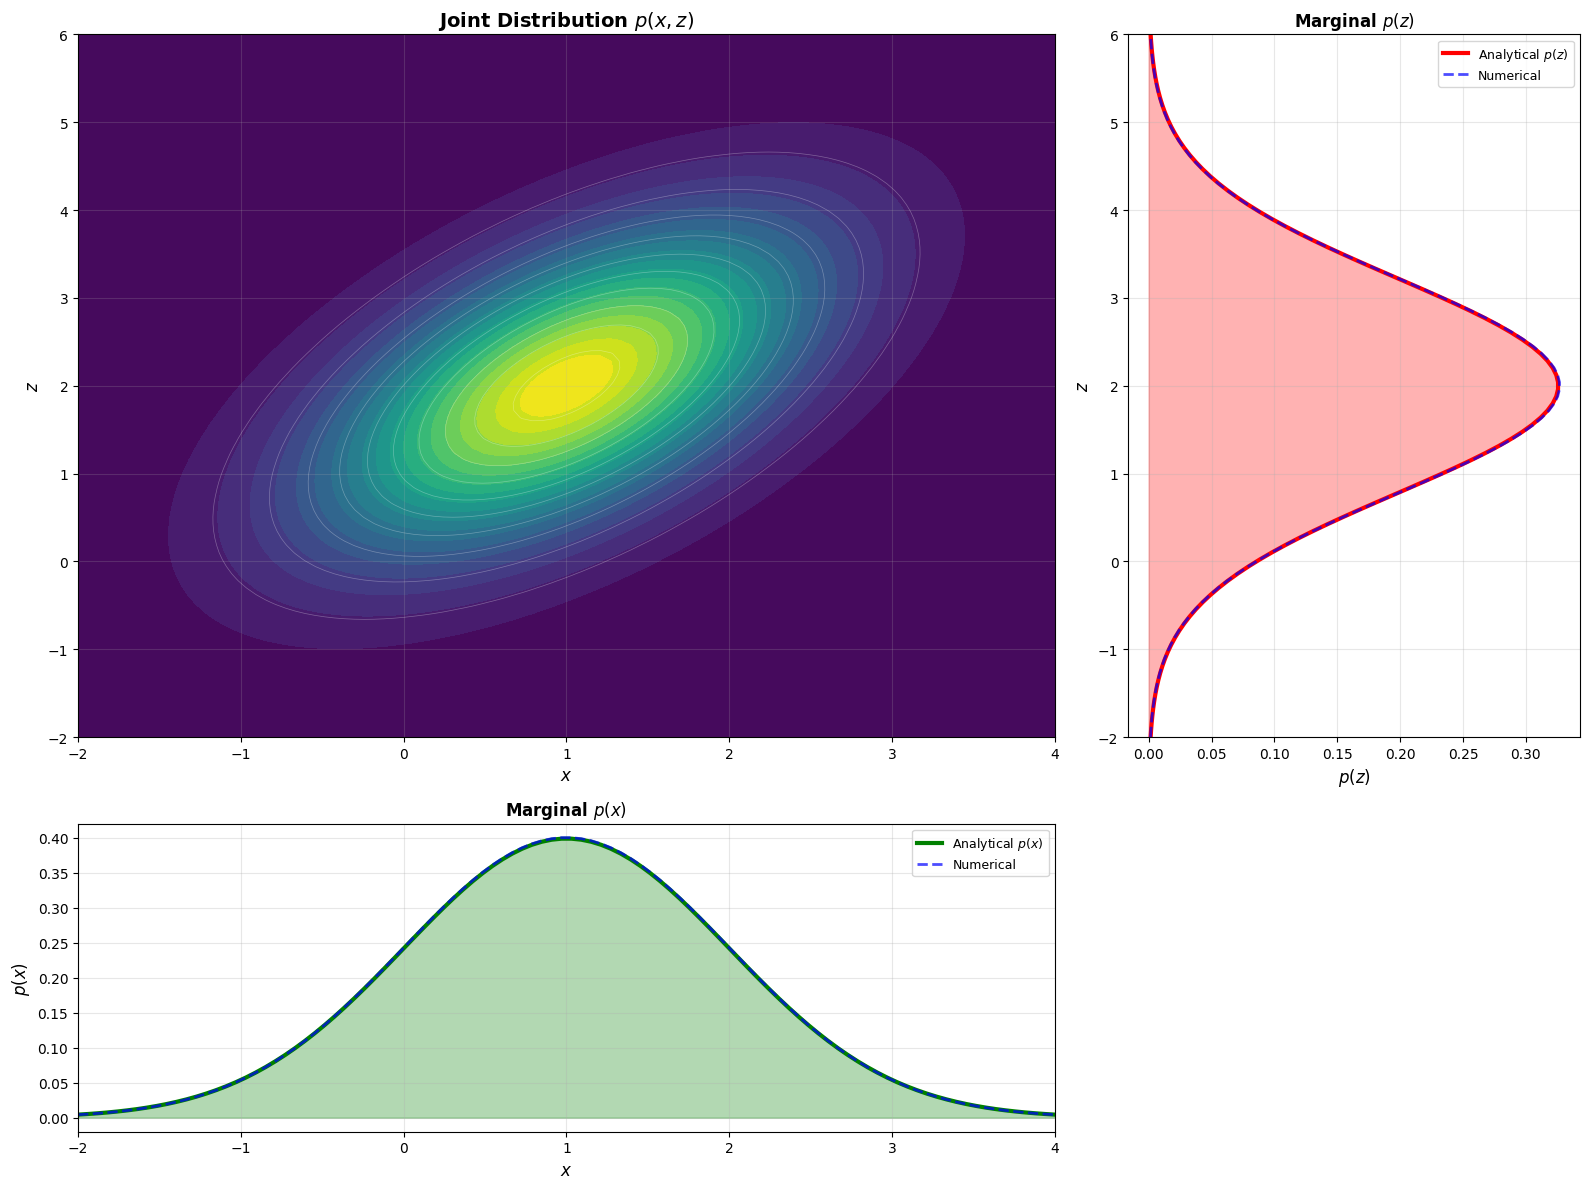

In [76]:
# Define a 2D Gaussian with correlation
mean = np.array([1.0, 2.0])
cov = np.array([[1.0, 0.7],
                [0.7, 1.5]])

# Create a grid
x_range = np.linspace(-2, 4, 100)
z_range = np.linspace(-2, 6, 100)
X, Z = np.meshgrid(x_range, z_range)

# Evaluate joint density p(x, z)
pos = np.dstack((X, Z))
joint_dist = multivariate_normal(mean, cov)
joint_pdf = joint_dist.pdf(pos)

# Compute marginal p(x) by integrating over z
# For a Gaussian, this is analytically known: p(x) ~ N(μ_x, Σ_xx)
marginal_x_mean = mean[0]
marginal_x_var = cov[0, 0]
marginal_x = stats.norm(marginal_x_mean, np.sqrt(marginal_x_var))
marginal_x_pdf = marginal_x.pdf(x_range)

# Compute marginal p(z) by integrating over x
marginal_z_mean = mean[1]
marginal_z_var = cov[1, 1]
marginal_z = stats.norm(marginal_z_mean, np.sqrt(marginal_z_var))
marginal_z_pdf = marginal_z.pdf(z_range)

# Numerical integration to verify
marginal_x_numerical = np.trapezoid(joint_pdf, z_range, axis=0)
marginal_z_numerical = np.trapezoid(joint_pdf, x_range, axis=1)

# Normalize numerical marginals
marginal_x_numerical = marginal_x_numerical / np.trapezoid(marginal_x_numerical, x_range)
marginal_z_numerical = marginal_z_numerical / np.trapezoid(marginal_z_numerical, z_range)

# Create visualization
fig = plt.figure(figsize=(16, 12))

# Top-left: 2D joint distribution
ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2, rowspan=2)
contour = ax1.contourf(X, Z, joint_pdf, levels=20, cmap='viridis')
ax1.contour(X, Z, joint_pdf, levels=10, colors='white', alpha=0.3, linewidths=0.5)
#plt.colorbar(contour, ax=ax1, label='$p(x, z)$')
ax1.set_xlabel('$x$', fontsize=12)
ax1.set_ylabel('$z$', fontsize=12)
ax1.set_title('Joint Distribution $p(x, z)$', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.2)

# Top-right: Marginal p(z)
ax2 = plt.subplot2grid((3, 3), (0, 2), rowspan=2)
ax2.plot(marginal_z_pdf, z_range, 'r-', linewidth=3, label='Analytical $p(z)$')
ax2.plot(marginal_z_numerical, z_range, 'b--', linewidth=2, 
        label='Numerical', alpha=0.7)
ax2.fill_betweenx(z_range, 0, marginal_z_pdf, alpha=0.3, color='red')
ax2.set_ylabel('$z$', fontsize=12)
ax2.set_xlabel('$p(z)$', fontsize=12)
ax2.set_title('Marginal $p(z)$', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(z_range[0], z_range[-1])

# Bottom-left: Marginal p(x)
ax3 = plt.subplot2grid((3, 3), (2, 0), colspan=2)
ax3.plot(x_range, marginal_x_pdf, 'g-', linewidth=3, label='Analytical $p(x)$')
ax3.plot(x_range, marginal_x_numerical, 'b--', linewidth=2,
        label='Numerical', alpha=0.7)
ax3.fill_between(x_range, 0, marginal_x_pdf, alpha=0.3, color='green')
ax3.set_xlabel('$x$', fontsize=12)
ax3.set_ylabel('$p(x)$', fontsize=12)
ax3.set_title('Marginal $p(x)$', fontsize=12, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)
ax3.set_xlim(x_range[0], x_range[-1])

plt.tight_layout()
plt.show()

Marginalization "collapses" the joint distribution onto one axis by integrating out the other variable. Think of it as viewing the shadow of a 3D object—you lose information about one dimension but get a simpler view.

The marginal distributions don't tell you anything about the correlation between $x$ and $z$. If you only observe $p(x)$ and $p(z)$ separately, could you reconstruct $p(x, z)$?

### Example: Conditional Sampling and the Joint Distribution

The joint distribution can be decomposed as $p(x, z) = p(x|z) p(z)$. Let's visualize how conditionals $p(x|z)$ for different values of $z$ shape the joint distribution.

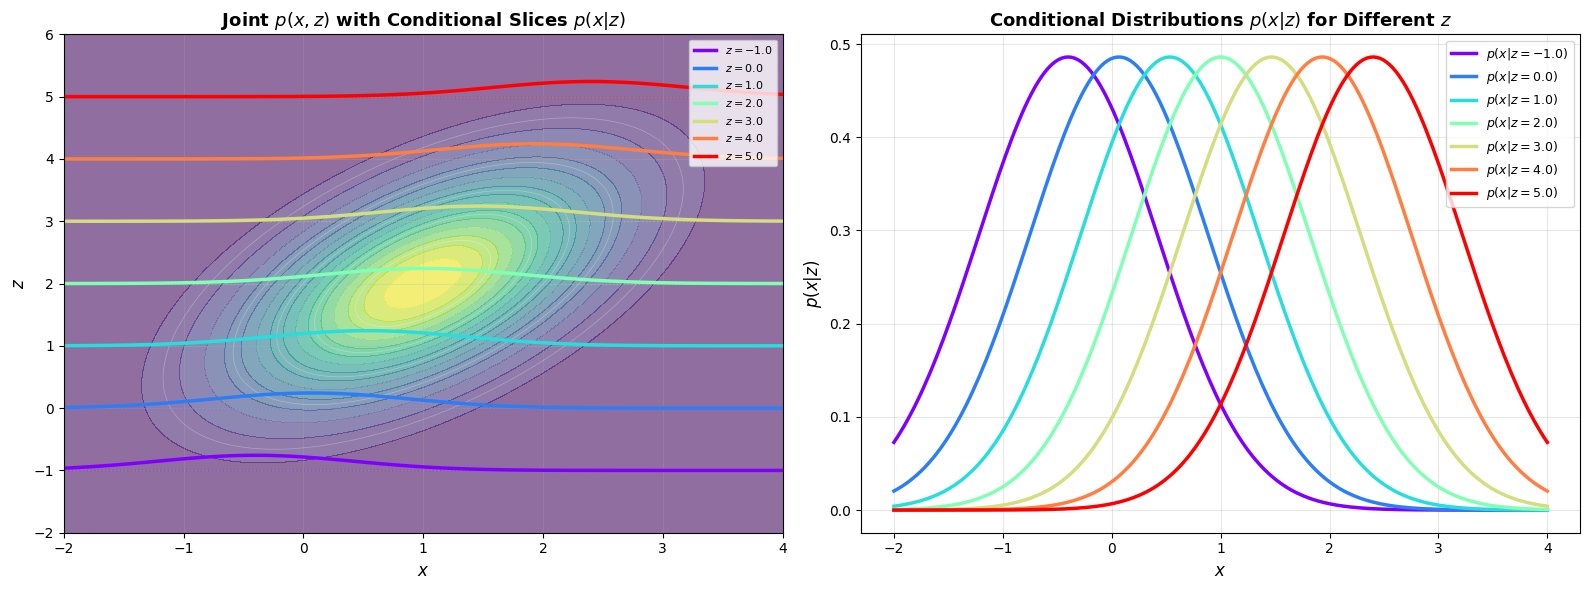

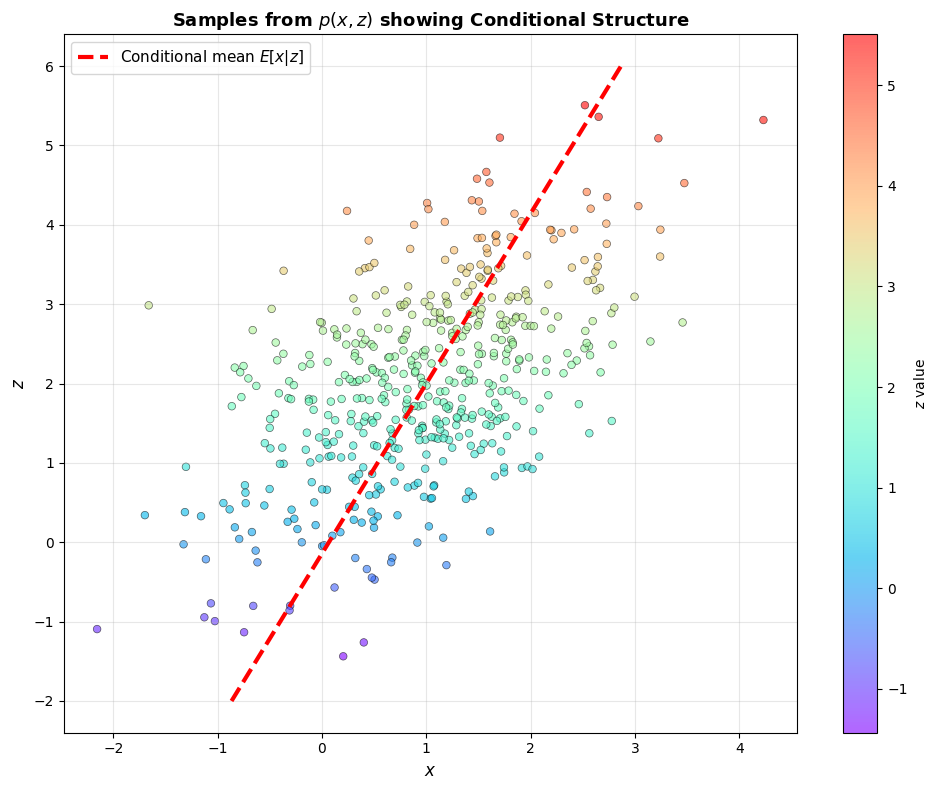

In [78]:
# Use same joint distribution as before
mean = np.array([1.0, 2.0])
cov = np.array([[1.0, 0.7],
                [0.7, 1.5]])

joint_dist = multivariate_normal(mean, cov)

# Select several z values to condition on
z_values = np.linspace(-1, 5, 7)

# For each z, compute the conditional p(x | z)
# For a 2D Gaussian: p(x|z) ~ N(μ_x + (Σ_xz/Σ_zz)(z - μ_z), Σ_xx - Σ_xz²/Σ_zz)
def conditional_params(z_val):
    """Compute parameters of p(x|z) for a 2D Gaussian"""
    mu_x, mu_z = mean[0], mean[1]
    sigma_xx = cov[0, 0]
    sigma_zz = cov[1, 1]
    sigma_xz = cov[0, 1]
    
    # Conditional mean and variance
    cond_mean = mu_x + (sigma_xz / sigma_zz) * (z_val - mu_z)
    cond_var = sigma_xx - (sigma_xz ** 2) / sigma_zz
    
    return cond_mean, cond_var

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Joint distribution with conditional slices
ax1 = axes[0]
X_grid = np.linspace(-2, 4, 100)
Z_grid = np.linspace(-2, 6, 100)
X_mesh, Z_mesh = np.meshgrid(X_grid, Z_grid)
pos_mesh = np.dstack((X_mesh, Z_mesh))
joint_pdf_mesh = joint_dist.pdf(pos_mesh)

contour = ax1.contourf(X_mesh, Z_mesh, joint_pdf_mesh, levels=15, cmap='viridis', alpha=0.6)
ax1.contour(X_mesh, Z_mesh, joint_pdf_mesh, levels=10, colors='white', alpha=0.3, linewidths=0.5)

# Draw conditional distributions as curves
colors = plt.cm.rainbow(np.linspace(0, 1, len(z_values)))

for z_val, color in zip(z_values, colors):
    # Compute conditional p(x | z)
    cond_mean, cond_var = conditional_params(z_val)
    cond_dist = stats.norm(cond_mean, np.sqrt(cond_var))
    
    # Scale pdf for visualization
    scale_factor = 0.5
    x_cond = X_grid
    pdf_cond = cond_dist.pdf(x_cond) * scale_factor
    
    # Plot as curve at height z
    ax1.plot(x_cond, z_val + pdf_cond, color=color, linewidth=2.5, label=f'$z={z_val:.1f}$')
    ax1.axhline(z_val, color=color, linestyle=':', alpha=0.3, linewidth=1)

ax1.set_xlabel('$x$', fontsize=12)
ax1.set_ylabel('$z$', fontsize=12)
ax1.set_title('Joint $p(x,z)$ with Conditional Slices $p(x|z)$', fontsize=13, fontweight='bold')
ax1.legend(fontsize=8, loc='upper right')
ax1.grid(True, alpha=0.2)

# Right plot: Individual conditionals
ax2 = axes[1]

for z_val, color in zip(z_values, colors):
    cond_mean, cond_var = conditional_params(z_val)
    cond_dist = stats.norm(cond_mean, np.sqrt(cond_var))
    
    x_plot = np.linspace(-2, 4, 200)
    pdf_plot = cond_dist.pdf(x_plot)
    
    ax2.plot(x_plot, pdf_plot, color=color, linewidth=2.5, label=f'$p(x|z={z_val:.1f})$')

ax2.set_xlabel('$x$', fontsize=12)
ax2.set_ylabel('$p(x|z)$', fontsize=12)
ax2.set_title('Conditional Distributions $p(x|z)$ for Different $z$', fontsize=13, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Sample from joint and visualize
np.random.seed(42)
n_samples = 500
samples = joint_dist.rvs(n_samples)

# Create scatter plot with conditional structure
fig, ax = plt.subplots(figsize=(10, 8))

# Plot samples colored by z-value
scatter = ax.scatter(samples[:, 0], samples[:, 1], c=samples[:, 1], 
                    cmap='rainbow', alpha=0.6, s=30, edgecolors='black', linewidths=0.5)
plt.colorbar(scatter, ax=ax, label='$z$ value')

# Overlay conditional means
z_plot = np.linspace(-2, 6, 50)
conditional_means = [conditional_params(z)[0] for z in z_plot]
ax.plot(conditional_means, z_plot, 'r--', linewidth=3, label='Conditional mean $E[x|z]$')

ax.set_xlabel('$x$', fontsize=12)
ax.set_ylabel('$z$', fontsize=12)
ax.set_title('Samples from $p(x,z)$ showing Conditional Structure', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The conditional distributions $p(x|z)$ show how knowing $z$ affects our beliefs about $x$. When variables are correlated, observing one variable shifts the expected value of the other. The "ridge" of the joint distribution follows the conditional mean. In VAEs and other latent variable models, we often work with $p(x|z)$ where the decoder generates $x$ given a latent code $z$.